# Data Quality

> All data is dirty, some data is useful.<br/>–c.f. George Box

Welcome to the mid-point of the book.  In something like the loose way in which a rock "concept album" tells an overarching story in its individual songs, this book is meant, to a certain degree, to follow the process a data scientist goes through from acquiring raw data to feeding suitable data into a machine learning model or data analysis.  Up until this point, we looked at how one goes about getting the data into a program or analysis system (e.g. a notebook) at all, and we touched on identifying data that has clearly "gone bad" at the level of individual data points in chapter 4.  In the chapters after this one we will look at remediation of that messy and marked data that earlier chapters delivered in stages.

Now, however, is the time to look for ways in which your data may have problems, not in its individual details, but in its overall "shape" and character.  In some cases, these problems will pertain to the general collection techniques used, and particular into systematic bias that might be introduced during collection.  In other cases, problems are not the fault of data collectors, but simply of units and scales, and correction can be quite mechanical and routine.  At this point we gradually ease into active interventions that do not simply detect dirt as we did hitherto, but also go about cleaning it.  One such cleanup might involve handling the inherent biases that cyclicities in data often create (often over time periods, but not exclusively).

In the last section of this chapter, we look at the idea of performing validation that is domain specific and utilizes rules that are practical, beyond being simply numeric.  Of course, every domain might have its own such rules, and an example in this chapter is meant to inspire thought, not to provide a blueprint for your specific tasks.  In fact, it can hardly be said often enough that everything within this book is meant to provide inspiration for ways of thinking about data science problems, and never merely recipes to copy directly to the task you have in front of you.

---

Before we get to the sections of this chapter, let us run our standard setup code.

In [1]:
from src.setup import *
%load_ext rpy2.ipython

In [2]:
%%capture --no-stdout err
%%R 
library(gridExtra)
library(tidyverse)

## Missing Data

> Absence of evidence is not evidence of absence.<br/>–Martin Rees

**Concepts**:

* Aspects of missing data
* Distribution of records in parameter space
* Bias in missing data

The story of missing data forms a trilogy in this book.  The prior chapter, chapter 4 (*Anomaly Detection*), led with a section on missing data.  In that case, our concern was to identify "missing-ness," which can be marked in various ways by various data sets in various data formats.  The next chapter, chapter 6 (*Value Imputation*), is primarily about what we might do to fill missing values with reasonable guesses.

This chapter falls between the previous and the next one.  We have already taken the mechanical or statistical tests to identify some data as missing (or as unreliable enough that it is better to pretend it is missing).  But we have not yet decided whether to keep or drop the observations to which those missing data points belong.  For this section, we need to access the significance of those missing data to our overall data set.

When we have a record with missing data, we essentially have two choices about its disposition.  On the one hand, we can discard that particular record.  On the other hand, we can impute some value for the missing value, as discussed in chapter 6.  Actually, in some sense there is a third options as well: we may decide that because of the amount or distribution of missing data in our data set, the data is simply not usable for the purpose at hand.  While, as data scientists we never want to declare a task hopeless, as responsible researchers we need to consider the possibility that particular data simply cannot support any conclusions.  Missing data is not the *only* thing that could lead us to this conclusion, but it is certainly one common fatal deficit.

If we wish to discard records—but also to a large extent if we wish to impute values—we need to think about whether what remains will be a fair representation of the parameter space of the data.  Sample bias can exist not only in the overall composition of a data set, but also more subtly in the distribution of missing values.  Keep in mind that "missing" here might result from the processing in chapter 4, in which some values may have been marked missing because we could determine they were unreliable, even if they were not per se absent in the raw data.

For example, I created a hypopthetical data set of persons with names, ages, gender, and favorite color and flower.  The ages, genders, and names, are modeled on the actual distribution of popular names over time reported by the United States Social Security Administration.  I assigned favorite colors and flowers to the people for this illustration.

In [3]:
df = pd.read_parquet('data/usa_names.parq') 
df

Age Gender      Name Favorite_Color Favorite_Flower
0      48      F      Lisa         Yellow           Daisy
1      62      F     Karen          Green            Rose
2      26      M   Michael         Purple            None
3      73      F  Patricia            Red          Orchid
...   ...    ...       ...            ...             ...
6338   11      M     Jacob            Red            Lily
6339   20      M     Jacob          Green            Rose
6340   72      M    Robert           Blue            Lily
6341   64      F     Debra         Purple            Rose

[6342 rows x 5 columns]

In general, this is an ordinary looking data set, with a moderately large collection of records.  We can notice in the data frame summary that at least some data is missing.  This is worth investigating more carefully.

In [4]:
with show_more_rows():
    print(df.describe(include='all'))

                Age Gender     Name Favorite_Color Favorite_Flower
count   6342.000000   6342     6342           5599            5574
unique          NaN      2       69              6               5
top             NaN      F  Michael         Yellow          Orchid
freq            NaN   3190      535            965            1356
mean      42.458846    NaN      NaN            NaN             NaN
std       27.312662    NaN      NaN            NaN             NaN
min        2.000000    NaN      NaN            NaN             NaN
25%       19.000000    NaN      NaN            NaN             NaN
50%       39.000000    NaN      NaN            NaN             NaN
75%       63.000000    NaN      NaN            NaN             NaN
max      101.000000    NaN      NaN            NaN             NaN


Using Panda's `.describe()` method or similar summaries by other tools allows us to see that `Age`, `Gender`, and `Name` have values for all 6,342 records.  However, `Favorite_Color` and `Favorite_Flower` are missing for approximately 750 records each.  In itself, missing data in 10-15% of the rows is quite likely not to be a huge problem.  This statement assumes that missingness is not itself biased. Even if we need to discard those records altogether, that is a relatively small fraction of a relatively large data set.  Likewise, imputing values would *probably* not introduce too much bias, and other features could be utilized within those records.  In the below section and in chapter 6 (*Value Imputation*), in relation to undersampling and oversampling, we discuss dangers of exclusion resulting in class imbalance.

While uniformly randomly missing data can be worked around relatively easily, data that is missing in a biased way can present a more significant problem.  To figure out which category we are in with this dataset, let us compare those missing flower preferences to the ages of the people.  Looking at every individual age up to 101 years old is hard to visualize; for this pupose we will group people into ten year age groups.  The graph below uses a statistical graphing library called **Seaborn** which is built on top of Matplotlib.

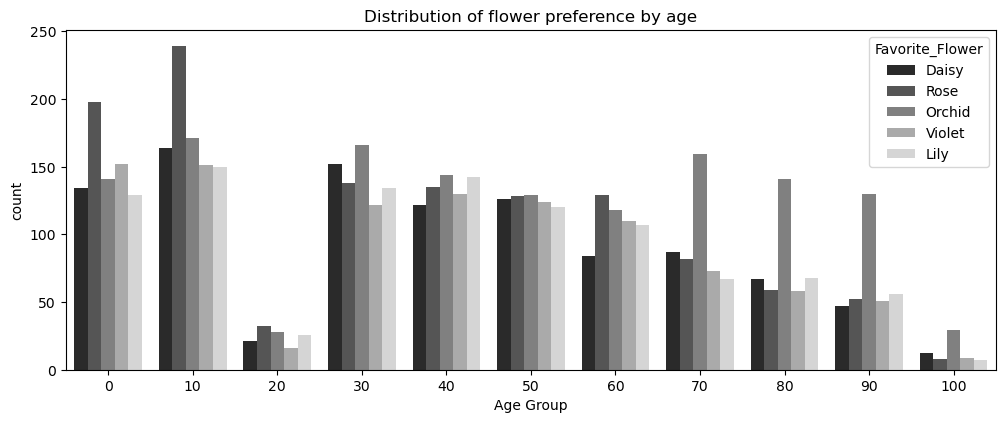

In [5]:
df['Age Group'] = df.Age//10 * 10
fig, ax = plt.subplots(figsize=(12, 4.5))
sns.countplot(x="Age Group", hue="Favorite_Flower", 
              ax=ax, palette='gray', data=df)
ax.set_title("Distribution of flower preference by age")
plt.savefig("img/(Ch05)Distribution of flower preference by age.png")

A few patterns jump out in this visualization.  It appears that older people tend to have a strong preference for orchids, and young people a moderate preference for roses.  This is perhaps a property of the data meriting analysis.  More signficantly for this section, there are few data points for favorite flower at all in the 20-30 age group.  One might imagine several explanations, but the true answer would depend on problem and domain knowledge.  For example, perhaps the data was not collected during a certain time period corresponding to these ages.  Or perhaps people in that age group reported a different favorite flower but its name was lost in some prior inaccurate data validation/cleaning step.

If we look at the records with missing color preference, we see a similar pattern in relationship to age.  However, the drop in frequency of available values occurs instead in the 30-40 age group. 

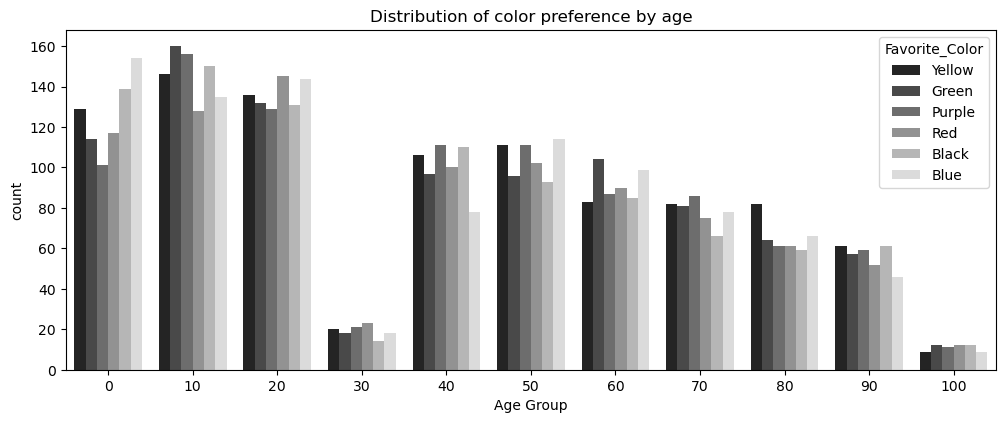

In [6]:
fig, ax = plt.subplots(figsize=(12, 4.5))
sns.countplot(x="Age Group", hue="Favorite_Color", 
              ax=ax, palette='gray', data=df)
ax.set_title("Distribution of color preference by age")
plt.savefig("img/(Ch05)Distribution of color preference by age.png")

If we were to drop *all* records with missing data, we would wind up with nearly no representation of people in the entire 20-40 age range.  This biased unavailability of data would be likely to weaken the analysis generally.  The number of records would remain fairly large, but the parameter space, as mentioned, would have an empty region (or at least much less densely occupied).  Obviously, these statements depend both on the purpose of our data analysis and our assumptions about the underlying domain.  If age is not an important aspect of the problem in general, our approach may not matter much.  But if we think age is a signficant independent variable, dropping this data would probably not be a workable approach.

This section, like many others, shows the kinds of exploration one should typically perform of a data set.  It does not provide one simple answer for the best remediation of bias in missing data.  That decision will be greatly dependent upon the purpose for which the data is being used and also on background domain knowledge that may clarify the reasons for the data being missing.  Remediation is inevitably a per-problem decision.

Let us turn to ways that bias might occur in relation to other features rather than simply globally in a data set.

## Biasing trends

> It is not the slumber of reason that engenders monsters, 
> but vigilant and insomniac rationality.<br/>–Gilles Deleuze

**Concepts**:

* Collection bias versus trends in underlying domain
* Perspective as source of bias
* Artifact of collection methods
* Visualization to identify bias
* Variance by group
* Externally identifying base rates

At times, you may be able to detect a sample bias within your data, and will need to make a domain area judgement about the significance of that bias.  There are at least two kinds of sample bias that you should be on the lookout for.  On the one hand, the distribution of observations may not match the distribution in the underlying domain.  Quite likely, you will need to consult other data sources—or simply use your own domain area knowledge—to detect such a skew in the samples.  On the other hand, the data themselves may reveal a bias by trends that exist between multiple variables.  In this latter case, it is important to think about whether the detected "trend" could be a phenomenon you have detected in the data, or is a collection or curation artifact.

### Understanding Bias

"Bias" is an important term in both statistics and human sciences, with a meaning that is strongly related, but that assumes a different valence across fields.  In the most neutral statistical sense, bias is simply the fact, more commonly true than not, that a data set does not accurately represent its underlying population of possible observations.  This bare statement hides more nuance than is evident, even outside of observations about humans and politically laden matters.  More often than not, neither we data scientists, who analyze data, nor the people or instruments that collected the raw data in the first place, can provide an unambiguous delineation of exactly what belongs to the underlying population.  In fact, the population is often somewhat circularly defined in terms of data collection techniques.

An old joke observes someone looking for their lost keys at night in the area under a street light.  Asked why they do not also look elsewhere, they answer that it is because the visibility is better where they are looking.  This is a children's joke, not told particularly engagingly, but it also lays the pattern for *most* data collection of *most* data sets.  Observers make observations of what they can *see* (metaphorically, most are probably voltages in an instrument, or bits on a wire, rather than actual human eyes), and not what they cannot.  Survivorship bias is a term for the cognitive error of assuming those observations we have available are representative of the underlying population.

It is easy not to be conscious of bias that exists in data, and probably that much easier when it indeed *does* concern human or social subjects and human observers bring in psychological and social biases.  But it is humans, in the end, even if aided by instruments we set up, who make observations of everything else too.  For example, the history of ethology (the study of animal behavior) is largely a history of scientists seeing the behaviors in animals that exist—or that they believe should exist—in the humans around them, that they impose by metaphor and blindness.  If you make a survey of books in your local library to determine the range of human literature or music, you will discover the predominance of writers and musicians who use your local language and play your local musical style.  Even in areas that seem most obviously *not about* humans, our vantage point may create a perspectival bias.  For example, if we catalog the types of stars that exist in the universe, and the prevalence of different types, we are always observing those within our cosmological horizon, which not only expresses an interaction of space and time, but also may not uniformly describe the entire universe.  Cosmologists know this, of course, but they know it as an inherent bias to their observations.

In this section, we will look at a version of the synthetic U.S. name/age data to detect both of these patterns.  As in the last section, this data approximately accurately represents the frequency of different names across different age groups, based on Social Security Administration data.  We can see that within the actual domain, the popularity of various names authentically changed over time.  As in the last section, it is useful to aggregate people into coarser age groups for visualization.

Throughout this book I have attempted to avoid social bias in the data sets I select or create as examples. For the imagined people in the rows of the name tables, I added features like favorite color or flower rather than more obviously ethnically or culturally marked features like eye color, favorite food, or musical preference.  Even those invented features I use are not entirely independent of culture though, and perhaps my position in the social world leads me to choose different factor values than would someone located elsewhere.  Moreover, by choosing the *top 5* most popular names in the United States each year, I impose a kind of majority bias: all are roughly Anglo names, and none, for example, are characteristically African-American, Latino, Chinese, or Polish, though such are all common outside of that top-5-by-year collation methodology.

In [7]:
names = pd.read_parquet('data/usa_names_states.parq')
names['Age Group'] = names.Age//10 * 10
names

Age Birth_Month         Name Gender            Home  Age Group
0      17        June      Matthew      M          Hawaii         10
1       5   September         Emma      F   West Virginia          0
2       4     January         Liam      M          Alaska          0
3      96       March      William      M        Arkansas         90
...   ...         ...          ...    ...             ...        ...
6338   29      August      Jessica      F   Massachusetts         20
6339   51       April      Michael      M         Wyoming         50
6340   29         May  Christopher      M  North Carolina         20
6341   62    November        James      M           Texas         60

[6342 rows x 6 columns]

The fields `Birth_Month` and `Home` are added to this data set, and let us stipulate that we suspect they may indicate some bias in the observations.  Before we look at that, let us take a look at a more-or-less expected trend.  Note that this data set was artificially constructed only based on the most popular male and female names for each birth year.   A particular name may not be in this top-5 (per gender) for a particular year, or even a particular decade, but nonetheless, a certain number of people in the USA were probably given that name (and would be likely to show up in non-synthetic data).

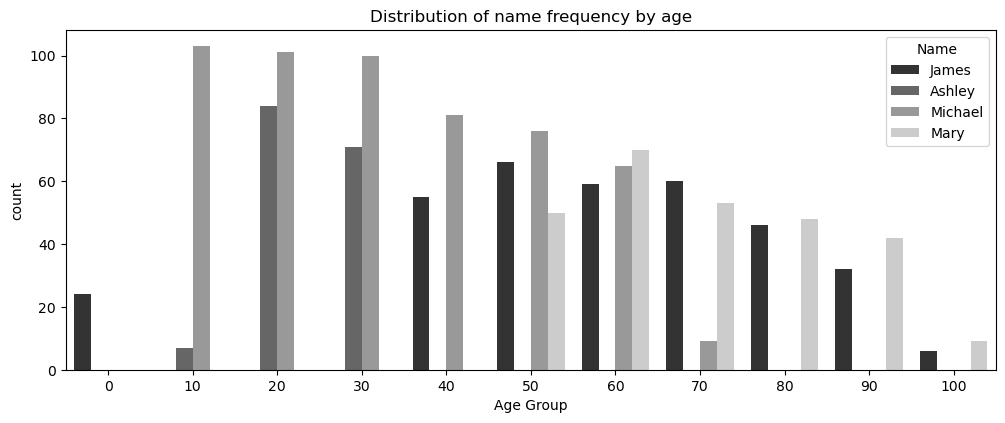

In [8]:
fig, ax = plt.subplots(figsize=(12, 4.5))
somenames = ['Michael', 'James', 'Mary', 'Ashley']
popular = names[names.Name.isin(somenames)]
sns.countplot(x="Age Group", hue="Name", 
              ax=ax, palette='gray', data=popular)
ax.set_title("Distribution of name frequency by age")
plt.savefig("img/(Ch05)Distribution of name frequency by age.png")

We can see trends in this data.  Mary is a popular name among the older people in the data set, but no longer shows up in the most popular names for younger people.  Ashley is very popular among 20-40 year olds, but we do not see it present outside that age group.  James seems to have been used over most of the age range, although it fell out of the top-5  spot among 10-40 year olds, resurging among children under 10.  Michael, similarly seems especially represented from 10-60 years of age.

The top-5 threshold used in generation of the data has definitely created a few artifacts in the visualization, but a general pattern of some names becoming popular and others waning is exactly a phenomenon we would expect with a bare minimum of domain knowledge.  Moroever, if we know only a little bit more about popular baby names in the United States, the specific distribution of names will seem plausible; both for the 4 shown and for the remaining 65 names that you can investigate within the data set if you download it.

### Detecting Bias

Let us apply a similar analysis to birth month as we did to name frequency.  A minumum of domain knowledge will tell you that while there are small annual cyclicities in birth month, there should not be a general trend over ages.  Even if some world historical event had dramatically affected births in one particular month of one particular year, this should create little overall trend when we aggregate over decades of age.

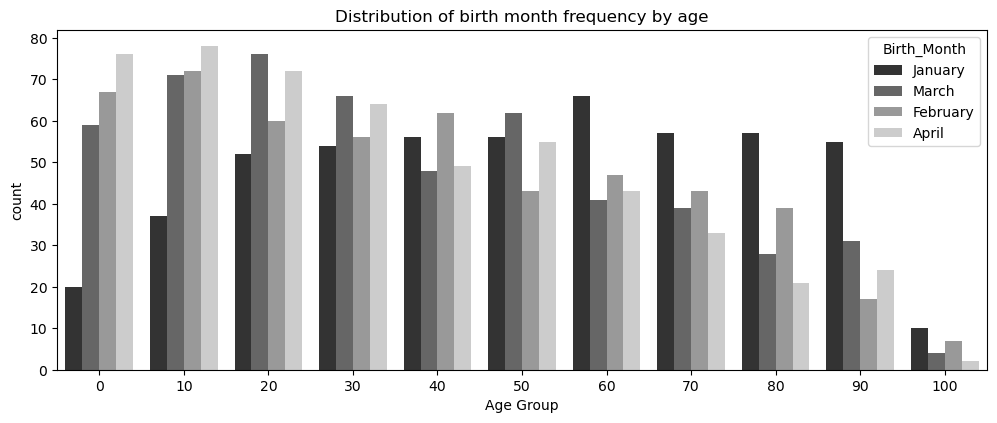

In [9]:
fig, ax = plt.subplots(figsize=(12, 4.5))
months = ['January', 'February', 'March', 'April']
popular = names[names.Birth_Month.isin(months)]
sns.countplot(x="Age Group", hue="Birth_Month", 
              ax=ax, palette='gray', data=popular)
ax.set_title("Distribution of birth month frequency by age")
plt.savefig("img/(Ch05)Distribution of birth month frequency by age.png")

Contrary to our hope of excluding a biasing trend, we have discovered that—for unknown reasons—January births are dramatically underrepresented among the youngest people and dramatically overrepresented among the oldest people.  This is overlain on an age trend of there being more young people, in general, but the pattern nonetheless appears strong.  We have not looked at months beyond April, but of course we could in a similar fashion.

A certain amount of random fluctuation occurs in the data set simply because of sampling issues.  The fact that April is a somewhat more common birth month for 50-something people than for 40-something people in the data set is quite likely meaningless since there are relatively few data points (on the order of 50) once we have cross-cut by both age and birth month.  Distinguishing genuine data bias from randomness can require additional analysis (albeit, by construction, the January pattern jumps out strongly even in the simple visualization).

There are numerous ways we might analyze it, but looking for notable differences in the spread of one variable in relation to another can be a good hint.  For example, we think we see an oddness in the pattern of January birth months, but is there a general irregularity in the distribution per age?  We *could* attempt to analyze this using exact age, but that probably makes the distinction too fine grained to have good subsample sizes.  The decade of age is an appropriate resolution for this test.  As always, think about your subject matter in making such judgements.

Since the number people of decreases with age, we need to find statistics that are not overly influencd by the raw numbers.  In particular, we can count the number of records we have for each age group and birth month and see if those counts are notably divergent.  Variance or standard deviation (of counts) will increase as the size of age group increases.  However, we can normalize that simply by dividing by the raw count within age group of all months.

A little bit of Pandas magic gets us this.  We want to group the data by the age group, look at the birth month, and count the number of records that fall within each Age ⨯ Birth_Month.  We wish to look at this in a tabular way rather than with a hierarchical index.  This operation arranges months in order of their occurrence in the data, but ordered by chronology is more friendly.

In [10]:
by_month = (names
    .groupby('Age Group')
    .Birth_Month
    .value_counts()
    .unstack())

by_month = by_month[month_names]
by_month

Birth_Month  January  February  March  April  May  June  July  August  \
Age Group                                                               
0                 20        67     59     76   66    77    71      65   
10                37        72     71     78   70    73    82      81   
20                52        60     76     72   65    65    71      66   
30                54        56     66     64   73    58    87      82   
...              ...       ...    ...    ...  ...   ...   ...     ...   
70                57        43     39     33   39    36    45      34   
80                57        39     28     21   31    37    23      28   
90                55        17     31     24   21    23    30      29   
100               10         7      4      2    6     2     4       6   

Birth_Month  September  October  November  December  
Age Group                                            
0                   67       67        56        63  
10                  83       79        70        79  
20                  68       75        76        71  
30                  66       65        57        58  
...                ...      ...       ...       ...  
70                  38       30        37        37  
80                  27       31        34        37  
90                  33       25        28        20  
100                  5        5         7         7  

[11 rows x 12 columns]

That data grid remains a bit too much to immediately draw a conclusion about, so as described, let us look at the normalized variance across age groups.

In [11]:
with show_more_rows():
    print(by_month.var(axis=1) / by_month.sum(axis=1))

Age Group
0      0.289808
10     0.172563
20     0.061524
30     0.138908
40     0.077120
50     0.059772
60     0.169321
70     0.104118
80     0.227215
90     0.284632
100    0.079604
dtype: float64


The over 100 year old group shows a low normalized variance, but it is a small subset.  Among the other age groups, the middle ages show a notably lower normalized variance across months than do the older or younger people.  This difference is quite striking for those under 10 and those over 80 years old.  We can reasonably conclude at this point that *some kind* of sample bias occurred in the collection of birth month; specifically, there is a different bias in effect based on age group of persons sampled.  Whether or not this bias *matters* for the purpose at hand, *the fact should be documented clearly* in any work products of your analyses or models.  In principle, some sampling technique discussed in chapter 6 (*Value Imputation*) might be relevant to adjust for this.

### Comparison to Baselines

The setup of this synthetic data set is a give-away, of course.  As well as introducing birth month, I also added `Home` in the sense of state or territory of residence and/or birth.  While there is no documented metadata that definitively clarifies the meaning of the column, let us take it as state of current residence.  If we had chosen to interpret it as birthplace, we might need to find historical data on populations at the times people of various ages were born; clearly that is possible, but the current assumption simplifies our task.

Let us take a look at the current population of the various U.S. states.  This will provide an external baseline relative to which to look for sample bias in the data set under consideration.

In [12]:
states = pd.read_fwf('data/state-population.fwf')
states

State  Population_2019  Population_2010  House_Seats
0        California         39512223         37254523         53.0
1             Texas         28995881         25145561         36.0
2           Florida         21477737         18801310         27.0
3          New York         19453561         19378102         27.0
..              ...              ...              ...          ...
52             Guam           165718           159358          0.5
53  U.S. Virgin Isl           104914           106405          0.5
54   American Samoa            55641            55519          0.5
55   N. Mariana Isl            55194            53883          0.5

[56 rows x 4 columns]

As most readers will know, the range of population sizes across different U.S. states and territories is quite large.  In this particular data set, representation of states in the House of Representatives is given as a whole number, but in order to indicate the special status of some entities that have non-voting representation, the special value of 0.5 is used (this is not germane to this section, just as a note).

Let us take a look at the distribution of home states of persons in the data set. The step of sorting the index is used to assure that states are listed in alphabetical order, rather than by count or something else.

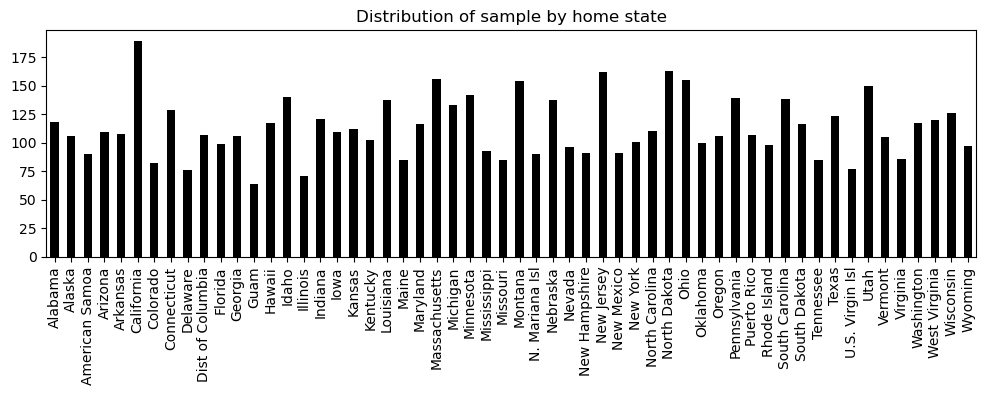

In [13]:
(names
    .Home
    .value_counts()
    .sort_index()
    .plot(kind='bar', figsize=(12, 3), 
          title="Distribution of sample by home state")
)
plt.savefig("img/(Ch05)Distribution of sample by home state.png")

There is clearly variation in the number of samples drawn from residents of each state.  However, the largest state represented, California, has only about 3x the number of samples as the smallest.  In comparison, a similar view of the underlying populations emphasizes the different distribution.

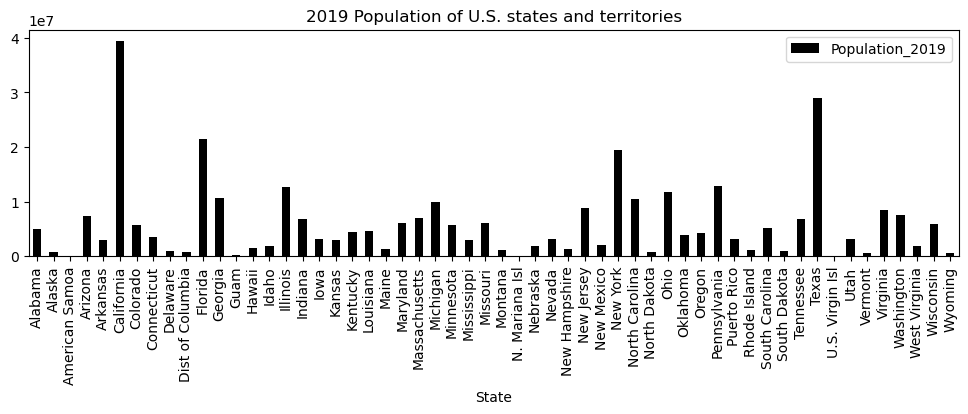

In [14]:
(states
    .sort_values('State')
    [['State', 'Population_2019']]
    .set_index('State')
    .plot(kind='bar', figsize=(12, 3),
          title="2019 Population of U.S. states and territories")
)
plt.savefig("img/(Ch05)2019 Population of U.S. states and territories.png")

While California provides the most samples for this data set, Californians are simultaneously the *most underrepresented* relative to the baseline population of the states.  As a general pattern, smaller states tend to be overrepresented generally.  We can, and probably should, think of this as selection bias based on the size of the various states.  As before, unless we have accurate documentation or metadata that describes the collection and curation procedures, we cannot be sure of the cause of the imbalance.  But a strong trend exists in this inverse relationship of population to relative sample frequency.

A note here is that sometimes sampling approaches deliberately introduce similar imbalances.  If the actual samples were precisely balanced, with some fixed N collected per state, this would fairly clearly point to such a deliberate categorical sampling as opposed to a sampling based on an underlying rate.  The pattern we actually have is less obvious than that.  We might form an hypothesis that the sampling rate is based on some other underlying feature not directly present in this data.  For example, perhaps a fixed number of observations were made in each *county* of each state, and larger states tend to have more counties (this is *not* the actual underyling derivation, but thinking in this manner should be in your mind).  Understanding data integrity issues resembles either a scientific process of experimentation and hypotheis, or perhaps even more so a murder mystery.  Developing a reasonable theory of *why* the data is dirty is always a good first step in remediating it (or even in ignoring the issue as not pertinent to the actual problem at hand).

Let us turn to evaluating the important of uneven distribution of categorical variables.

### Benford's Law

There is a curious fact about the distribution of *digits* in many observed numbers called "Benford's Law."  For a large range of real-world data sets, we see leading "1" digits far more often than leading "2"s, which in turn occur far more commonly than leading "3"s, etc.  If you see this pattern, it probably does not reflect harmful bias; in fact, for many kinds of observations, if you *fail to* see it, that might itself reflect bias (or even fraud).

If a distribution precisely follows Benford's Law, it will specifically have digits distributed as:

$$P(d) = log_{10}\left(1 + \frac{1}{d}\right)$$

However, this distribution is often only approximate for real-world data.

When data is distributed according to a power law or a scaling factor, it becomes relatively intuitive to understand what leading digits will be distributed in a "biased" way.  However, much observational data that is not obviously scaling in nature still follows Benford's Law (at least approximately).  Let us pick an example to check; I scraped and cleaned up formatting for the populations and areas of the most populous U.S. cities.

In [15]:
cities = pd.read_fwf('data/us-cities.fwf')
cities

NAME  POP2019  AREA_KM2
0    New York City  8336817     780.9
1      Los Angeles  3979576    1213.9
2          Chicago  2693976     588.7
3          Houston  2320268    1651.1
..             ...      ...       ...
313      Vacaville   100670      75.1
314        Clinton   100471      72.8
315           Bend   100421      85.7
316     Woodbridge   100145      60.3

[317 rows x 3 columns]

Let us first count the leading digits of populations.

In [16]:
pop_digits =  cities.POP2019.astype(str).str[0].value_counts()
with show_more_rows():
    print(pop_digits)

1    206
2     53
3     20
4     10
6      9
5      8
8      5
7      3
9      3
Name: POP2019, dtype: int64


Asking the same question of area in square kilometers.

In [17]:
area_digits =  cities.AREA_KM2.astype(str).str[0].value_counts()
with show_more_rows():
    print(area_digits)

1    118
2     47
3     31
4     23
8     21
9     21
7     20
6     20
5     16
Name: AREA_KM2, dtype: int64


Neither collection of data *exactly* matches the Benford Law ideal distribution, but both show the general pattern of favoring leading digits in roughly ascending order.

## Class imbalance

> It seems to be correct to begin with the real and the concrete, with 
> the real precondition, thus to begin [...] with the population.  However, 
> on closer examination this proves false. The population is an abstraction 
> if I leave out, for example, the classes of which it is composed.<br/>
> –Karl Marx

**Concepts**:

* Predicting rare events
* Imbalance in features versus in targets
* Domain versus data integrity imbalance
* Forensic analysis of sources of imbalance
* Stipulating the direction of causality

The data you receive will have imbalanced classes, if it has categorical data at all.  The several distinct values that a categorical variable may have are also sometimes called *factor levels* ("factor" is synonymous with "feature" or "variable", as discussed in the Preface and Glossary). Moreover, as discussed in the chapter 6 (*Value Imputation*) section on *Sampling*, dividing a continuous variable into increments can often usefully form synthetic categories also.  In principle, any variable might have a categorical aspect, depending on the purpose at hand.  When these factor levels occur with notably different frequency it may show selection bias or some other kind of bias; however, it very often simply represents the inherent nature of the data, and is an essential part of the observation.

A problem arises because many types of machine learning models have difficulty predicting rare events.  Discussion of concretely rebalancing classes is deferred until the chapter 6 discussion of undersampling and oversampling, but here we at least want to reflect on identifying class imbalance.  Moreover, while many machine learning techniques are highly sensitive to class imbalance, others are more-or-less indifferent to it.  Documentation of the characteristics of particular models, and their contrast with others, is outside the scope of this particular book.

In particular, though, the main difference in when class imbalance poses a difficulty versus when it is central to the predictive value of the data, is precisely the difference between a target and the features.  Or equivalently, the difference between a dependent variable and independent variables.  When we think of a rare event that might cause difficulty for a model, we usually mean a rare target value, and only occasionally are concerned about a rare feature.  When we wish to use sampling to rebalance classes, it is almost always in relation to target class values.

We will work with a simple example.  Two weeks of Apache server logs from my web server are provided as sample data.  Such a log file has a number of features encoded in it, but one particular value in each request is the HTTP status code returned.  If we imagine trying to model the behavior of my web sever, quite likely we would wish to treat this status code as a target that might be predicted by the other (independent) variables.  Of course, the log file itself does not impose any such purpose, it simply contains data on numerous features of each request (including response).

The status codes returned from the actual requests to my web server are extremely unbalanced, which is generally a good thing.  I want most requests to result in "200 OK" responses (or at least *some* 2xx code).  When they do not, there is either a problem with the URLs that users have utilized or there is a problem with the web server itself.  Perhaps the URLs were published in incorrect form, such as in links from other web pages; or perhaps deliberately wrong requests were used in attempts to hack my server.  I never really *want* a status code outside of 2xx, but inevitably some arise.  Let us look at their distribution:

In [18]:
%%bash
zcat data/gnosis/*.log.gz | 
    cut -d' ' -f9 | 
    sort | 
    uniq -c

  10280 200
      2 206
    398 301
   1680 304
    181 403
    901 404
      9 500


The 200 status dominates here.  The next highest occurrence is "304 Not Modified" which is actually fine as well.  It simply indicates that a cached copy on a client remains current.  Those 4xx and 5xx (and perhaps 301) status codes are generally undesirable events, and I may want to model the patterns that cause them.  Let us remind ourselves what is inside an Apache `access.log` file (the name varies by installation, as can the exact fields).

In [19]:
%%bash
zcat data/gnosis/20200330.log.gz | head -1 | fmt -w50

162.158.238.207 - - [30/Mar/2020:00:00:00 -0400]
"GET /TPiP/024.code HTTP/1.1" 200 75


There is a variety of data in this line, but notably it is easy to think of pretty much all of it as categorical.  The IP address is a *dotted quad*, and the first (and often second) quad tends to be correlated with the organization or region where the address originates.  Allocation of IPv4 addresses is more complex than we can detail here, but it may be that requests originating from a particular /8 or /16 origin tend to get non-200 responses.  Likewise, the date—while unfortunately not encoded as ISO-8601 format—can be thought of as categorical fields for month, hour, minute, and so on.

Let us show a bit of Pandas code to read and massage these records into a data frame.  The particular manipulations done are not the main purpose of this section, but gaining familiarity with some of these methods is worthwhile. 

One thing to notice, however, is that I have decided that I am not really concerned with the pattern where e.g. my web server became erratic for a day.  That has not occurred in this particular data, but if it had I would assume that was a one-off occurrence not subject to analysis.  The separate cyclical elements of hour and minute might detect recurrent issues (which are discussed more in later sections of this chapter).  Perhaps, for example, my web server gives many 404 responses around 3 a.m., and that would be a pattern/problem worth identifying.

In [20]:
def apache_log_to_df(fname):
    # Read one log file.  Treat is as a space separated file
    # There is no explicit header, so we assign columns
    cols = ['ip_address', 'ident', 'userid', 'timestamp', 
            'tz', 'request', 'status', 'size']
    df = pd.read_csv(fname, sep=' ', header=None, names=cols)
    
    # The first pass gets something workable, but refine it
    # Datetime has superfluous '[', but fmt matches that
    fmt = "[%d/%b/%Y:%H:%M:%S"
    df['timestamp'] = pd.to_datetime(df.timestamp, format=fmt)
    
    # Convert timezone to an integer
    # Not general, I know these logs use integral timezone
    # E.g. India Standard Time (GMT+5:30) would break this
    df['tz'] = df.tz.str[:3].astype(int)
    
    # Break up the quoted request into sub-components
    df[['method', 'resource', 'protocol']] = (
                df.request.str.split(' ', expand=True))
    
    # Break the IP address into each quad
    df[['quad1', 'quad2', 'quad3', 'quad4']] = (
                df.ip_address.str.split('.', expand=True))
    
    # Pandas lets us pull components from datetime
    df['hour'] = df.timestamp.dt.hour
    df['minute'] = df.timestamp.dt.minute
    
    # Split resource into the path/directory vs. actual page
    df[['path', 'page']] = (
                df.resource.str.rsplit('/', n=1, expand=True))
    # Only care about some fields for current purposes
    cols = ['hour', 'minute', 
            'quad1', 'quad2', 'quad3', 'quad4', 
            'method', 'path', 'page', 'status']
    return df[cols]

This function allows us to read all of the daily log files into a single Pandas DataFrame simply by mapping over the collection of file names and concatenating data frames.  Everything except perhaps `page` in the resulting data frame is reasonable to think of as a categorical variable.

In [21]:
reqs = pd.concat(map(apache_log_to_df, 
                 glob('data/gnosis/*.log.gz')))
# Each file has index from 0, so dups occur in raw version
reqs = reqs.reset_index().drop('index', axis=1)
# The /16 subnetwork is too random for this purpose
reqs.drop(['quad3', 'quad4'], axis=1, inplace=True)
reqs

hour  minute quad1 quad2 method                           path  \
0         0       0   162   158    GET    /download/pywikipedia/cache   
1         0       3   172    68    GET                          /TPiP   
2         0       7   162   158    GET  /download/pywikipedia/archive   
3         0       7   162   158    GET                     /juvenilia   
...     ...     ...   ...   ...    ...                            ...   
13447    23      52   162   158    GET          /download/gnosis/util   
13448    23      52   172    69    GET                                  
13449    23      52   162   158    GET               /publish/resumes   
13450    23      56   162   158    GET    /download/pywikipedia/cache   

                                 page  status  
0       DuMont%20Television%20Network     200  
1                            053.code     200  
2                            ?C=N;O=A     200  
3      History%20of%20Mathematics.pdf     200  
...                               ...     ...  
13447                     hashcash.py     200  
13448                     favicon.ico     304  
13449                                     200  
13450           Joan%20of%20Lancaster     200  

[13451 rows x 8 columns]

Within my web server, I have relatively few directories where content lives, but relatively many different concrete pages within many of those directories.  In fact, the path `/download/pywikipedia/cache` is actually a robot that performs some formatting cleanup of Wikipedia pages that I had forgotten that I left running 15+ years ago.  Given that it may be pointed to any Wikipedia page, there is effectively an infinite space of possible pages my server will reply to.  There are also a small number of long path components because URL parameters are sometimes passed in to a few resources.  Let us visualize the distribution of the other features in this data set, with an eye to the places where class imbalance occurs.

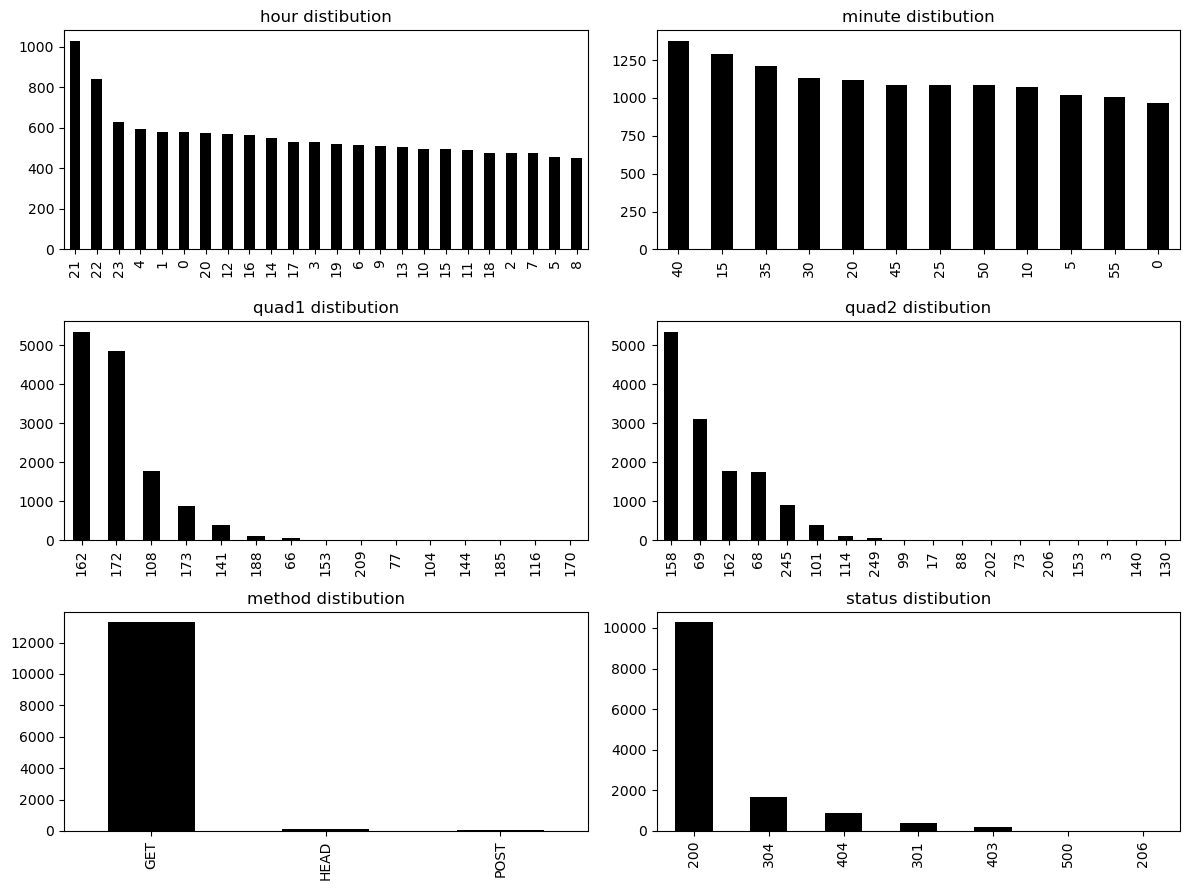

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(12, 9))

# Which factors should we analyze for class balance?
factors = ['hour', 'minute', 'quad1', 'quad2', 'method', 'status']

# Loop through the axis subplots and the factors
for col, ax in zip(factors, axes.flatten()):
    # Minute is categorical but too many so quantize
    if col == 'minute':
        data = (reqs[col] // 5 * 5).value_counts()
    else:
        data = reqs[col].value_counts()
    data.plot(kind='bar', ax=ax)
    ax.set_title(f"{col} distibution")

# Matplotlib trick to improve spacing of subplots
fig.tight_layout()
plt.savefig("img/(Ch05)web-traffic feature distributions.png")

In the plots we see some highly imbalanced classes and some mostly balanced ones.  The hours show a minor imbalance, but with a fairly strong pattern of more requests around 21:00–24:00 in Atlantic Daylight Time.  Why my hosted server is in that timezone is unclear to me, but this is around 6 p.m. US Pacific Time, so perhaps users in California and British Columbia tend to read my pages after work.  The distribution of 5 minute increments within an hour is generally uniform, although the slight elevation of a few increments could possibly be more than random fluctuation.

The imbalance in the initial quads of IP address seems striking, and might initially suggest an important bias or error.  However, after probing only slightly deeper, we can determine using online "whois" databases that (at the time of this writing) both 162.158.0.0/16 and 172.69.0.0/16 are assigned to the CDN (content delivery network) that I use to proxy traffic.  So the imbalance in these features has simply provided a clue that almost all requests are proxied through a known entity.  In particular, it means that we are unlikely to be able to use these features usefully in any kind of predictive model.  At most, we might perform feature engineering—as discussed in chapter 7 (*Feature Engineering*)—to create a derived feature such as `is_proxied`.

The class imbalances that remain are in the HTTP method and in the status code returned.  In neither case is it at all surprising that GET and 200 dominate the respective features.  This is what I expect, and even hope for, in the behavior of my web server and web site.  So nothing there suggests bias in the data collection; since *all* requests were logged, this is not a sample but rather a complete domain.  As a side note, the population is specifically delineated, and cannot necessarily be used to describe anything beyond those lines.  These are all requests made to port 80 or port 443 for the web domain gnosis.cx, between March 29, 2020 and April 11, 2020; we can draw no conclusion about other web domains or other dates without further analysis or reasoning about how typical this data is of the web as a whole.

As data scientists, we are not necessarily constrained by temporal causality.  For example, it is clear that in a literal and sequential way, the requesting IP address, possibly the userid, maybe the time of the request, and definitely the URL of the request, both method and path, will *cause* a certain status code and number of bytes to be returned.  In many cases (probably all of them on my simple, static website), the size is simply that of the underlying HTML page.  But in concept, a server might do something different depending on the date and time, or on the requesters address.  In any case, certain *facts* about the request exist a few milliseconds before the server decides on the appropriate status code and response size and logs all of that.

However, for an analysis, we might want to make predictions that exactly reverse causality.  Perhaps we would like to treat the size of the response as an independent variable in our effort to predict time of day.  For example, it could be that large files are always requested around 7 p.m. rather than at other times. Our *model* might try to predict a cause from its effect—and that is perfectly legitimate in data science, as long as we are aware of it.  In fact, we may only look for correlations, entirely ignoring for a particular task the potential hidden cause of multiple features.  Data science is something different from other sciences; the endeavors are, hopefully, complementary.

---

For this section, we focused merely on recognizing, and to a limited extent analyzing, class imbalance.  What it means for the actual task to which we wish to put this data is another matter.  A significant distinction to keep in mind is that between independent and dependent variables.  Generally, imbalance in a dependent variable will skew classification models in a more important way than imbalance in an independent variable.  So, for example, if we wish to predict the likely status code that will be produced by a request based on other features of the request, we would be likely to use sampling techniques discussed in chapter 6 (*Value Imputation*) to *balance the data set* synthetically.

On the other hand, class imbalance is not completely irrelevant in independent variables, at least not for all kinds of models.  This very much depends on the kind of model.  If we use something in the family of decision trees, for example, it makes little difference that HEAD requests are rare if we wish to detect the (hypothetical) fact that HEAD is strongly associated with 500 status codes.  However, if we use a K-nearest neighbors family of algorithm, the actual distance in parameter space can be important.  Neural networks fall somewhere in the middle in terms of sensitivity to class imbalance in independent variables. If we encode the HTTP method either as an ordinal value or using one-hot encoding, we may naïvely *underweight* that strong but rare feature.  One-hot encoding is discussed in chapter 7 (*Feature Engineering*).  For an independent variable, we would not generally wish to *oversample* a rare factor level; but we might wish to artificially *overweight* it.

We also should think about the numeric ranges of data, which might reflect very different underlying units.

## Normalization and scaling

> Measure with a micrometer. Mark with chalk.. Cut with an axe.<br/>–Rule for precision

**Concepts**:

* The effect of numeric ranges in variables
* Univariate and multivariate effects
* Numeric forms of various scalers
* Factor and sample weighting

The idea behind normalization of data is simply bringing all the features being utilized in a data set into a comparable numeric range.  When starkly different units are used for different features—that is, for dimensions of a parameter space—some machine learning models will disproportionately utilize those features which simply have a larger numeric range.  Special cases of differently scaled numeric ranges occur when one feature has outliers that have not been removed, or when one feature is normally distributed but another feature is exponentially distributed.

This book generally steers away from showing machine learning examples or code.  There are many wonderful libraries that address that 20% of your work, as a data scientist, that you will do after you have done the 80% that this book teaches you.  However, to emphasize the motivation for normalization, we will create a very simple ML model on some overly neat data that illustrates an overwhelming benefit with scaling.  For this example, a small amount of code in scikit-learn is used.  Notably, however, the scaler classes in scikit-learn are extremely useful even if you do not wish to use that library for modeling.  It is certainly reasonable—and perhaps even best practice within Python—to use scikit-learn even if you only ever perform normalization with it.

The synthetic data set here has two features and one target; all are continuous variables.

In [23]:
unscaled = make_unscaled_features()
unscaled

Feature_1     Feature_2     Target
0     0.112999  19247.756104  11.407035
1     0.204178  23432.270613  20.000000
2     0.173678  19179.445753  17.336683
3     0.161411  17579.625264  16.633166
..         ...           ...        ...
196   0.137692  20934.654450  13.316583
197   0.184393  18855.241195  18.241206
198   0.177846  19760.314890  17.839196
199   0.145229  20497.722353  14.371859

[200 rows x 3 columns]

At a glance, we can see that the Target values are on the order of 15, while Feature_1 is on the order of 0.1 and Feature_2 is on the order of 20,000.  The invented example does not assign any specific units for these measures, but there are many quantities you might measure whose units produce numeric values in those ranges.  As an initial question, we might ask whether any of the features have a univariate correlation with the target.  A machine learning model will find more than just this, but it is a useful first question.

In [24]:
unscaled.corr()

Feature_1  Feature_2    Target
Feature_1   1.000000  -0.272963  0.992514
Feature_2  -0.272963   1.000000 -0.269406
Target      0.992514  -0.269406  1.000000

We see that Feature_1 has a very strong positive correlation with the Target, and Feature_2 has a moderate negative correlation.  So on the face of it, a model should have plenty to work with.  Indeed, we can tell from the correlation matrix that linear models would do extremely well, with or without normalization; but that is the topic of a different book.  This point can be made visually by plotting Target against each feature.  

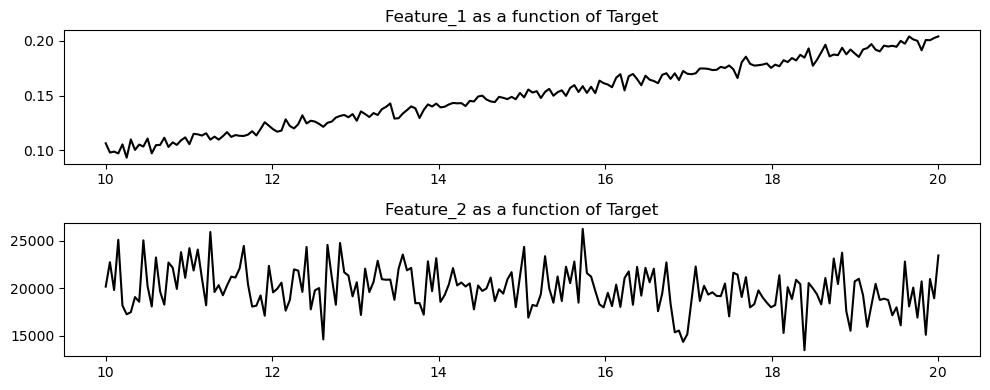

In [25]:
plot_univariate_trends(unscaled)

Feature_1 has a visually obvious correlation, Feature_2 reveals at most a very weak one to a human eye.

### Applying a Machine Learning Model

As promised, let us apply a machine learning model against this data, trying to predict the target based on the features.  In ML, we conventionally use the names X and y for features and target, respectively.  This follows the common pattern, from high school algebra, of naming an independent variable 'x' and a dependent variable 'y'. Since we generally have multiple features, a capital 'X' is used.  While we cannot discuss the motivation in any depth, good practice in machine learning is to always reserve a portion of your training data for testing, so that you do not overfit your model.  That is done with the function `train_test_split()`.

In [26]:
from sklearn.model_selection import train_test_split

X = unscaled.drop('Target', axis=1)
y = unscaled['Target']

X_train, X_test, y_train, y_test = (
    train_test_split(X, y, random_state=1))

For the example, we use a K-neighbors regressor to try to model our data.  For many kinds of problems, this is a very effective algorithms, but it is also one that looks directly at distances in parameter space, and is hence very sensitive to scaling.  If we naïvely apply this model to our raw data, the R-squared score is very low (other metrics would be similarly bad).

In [27]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
knn.fit(X_train, y_train).score(X_test, y_test)

0.027756186064182953

A "perfect" R-squared score is 1.0.  A very bad score is 0.0 (negative scores are also sometimes possible, and even worse in a sense.  But for anything below 0.25 or so, we essentially reject the model.

By using, in this case, a min-max scaler, we achieve a far better metric score.  The scaler we use here simply takes the minimum value of the raw feature, and shifts all values by that amount toward zero by subtraction, then divides all values by the shifted maximum value.  The effect is to produce a range that is always [0, 1], for every feature.  This synthetic feature does not have any physical meaning per se, as the original measure presumably did.  But by applying this scaler, all features are guaranteed to occupy the same numeric range (with the specific values distributed differently within their ranges). Let us apply this min-max scaling to our features before fitting the model again.

In [28]:
from sklearn.preprocessing import MinMaxScaler
X_new = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = (
    train_test_split(X_new, y, random_state=1))

knn2 = KNeighborsRegressor()
knn2.fit(X_train, y_train).score(X_test, y_test)

0.9743878175626131

Notice that I did not bother to scale the target in the above code.  There would be no harm in doing so for the model, but there is no benefit either since the target is not part of the parameter space of the features.  Moreover, if we scaled the target, we would have to remember to unscale it correspondingly to get a meaningful number in the desired units.

### Scaling Techniques

The scaling technique we used above utilized scikit-learn's MinMaxScaler.  All of the scalers in scikit-learn use the same API, and are implemented in an efficient and correct manner.  There is certainly a good argument for using those within Python, even if scikit-learn is not otherwise part of your overall modeling pipeline.  However, it is not difficult to do the same scaling "by hand" using lower-level vectorized operations.  For example, this would be simple in NumPy, here we show an example in R, and focus only on the algorithm.  One nice detail of the scikit-learn API is that it knows to normalize column-by-column.  In the comparison, we only do one column.

In [29]:
%%R -i X,X_new
# Import the data frame/array from Python
py_raw_data <- X$Feature_1  # only feature 1
py_scaled <- X_new[,1]      # scaled column 1

# Utility function to scale as [0, 1]
normalize <- function(x) {
    floor <- min(x)  # Only find min once
    return ((x - floor) / (max(x) - floor))
}

# Scale the raw data
r_scaled <- normalize(py_raw_data)

# Near equality of elements from normalize() and MinMaxScaler
all.equal(py_scaled, r_scaled)

[1] TRUE


Notice that even for a straightforward operation like this, the different implementations, across libraries and languages, do not perform identical operations in an identical order.  This allows for some floating-point rounding differences to creep in.  Comparing for strict equality of floating-point values is almost always the wrong thing to do; measurements have finite precision and operations introduce 1-ULP (unit in the last place) errors frequently.  On the other hand, these slight numeric differences make no practical difference for actual models, only for equality checks. 

In [30]:
%%R
print("A few 'equalities':")
print(py_scaled[1:5])
print(r_scaled[1:5])

print("Exactly equal?")
print((py_scaled == r_scaled)[1:10])

print("Mean absolute difference:")
print(mean(abs(py_scaled - r_scaled)))

[1] "A few 'equalities':"
[1] 0.1776148 1.0000000 0.7249096 0.6142706 0.8920478
[1] 0.1776148 1.0000000 0.7249096 0.6142706 0.8920478
[1] "Exactly equal?"
 [1]  TRUE FALSE FALSE FALSE FALSE  TRUE FALSE  TRUE  TRUE  TRUE
[1] "Mean absolute difference:"
[1] 6.130513e-17


Another very common scaling technique is called StandardScaler in scikit-learn.  It sets the mean of a feature to zero and the standard deviation to one.  This scaling is particularly relevant when a variable is (very roughly) normally distributed.  The name hints that this approach is usually the default scaler to choose (although probably it derives from "standard deviation" when the name was chosen).  Let us implement it to illustrate the simple transformation.  Here we display the values from Feature_2 which are around 20,000 in the raw data.

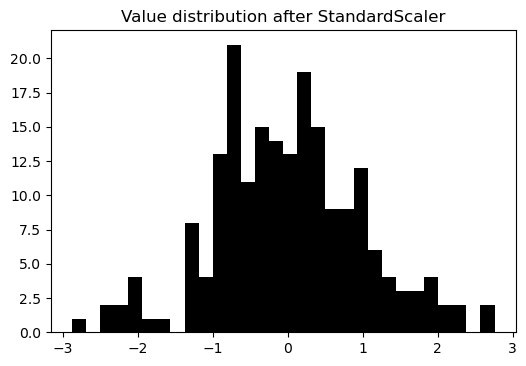

In [31]:
from sklearn.preprocessing import StandardScaler
X_new2 = StandardScaler().fit_transform(X)

# Second column for example (both were scaled)
plt.hist(X_new2[:, 1], bins=30)
plt.title("Value distribution after StandardScaler")
plt.savefig("img/(Ch05)Value distribution after StandardScaler.png")

The StandardScaler uses more numeric operations than MinMaxScaler, since it involves standard deviation, and that gives the calculation more opportunity for introducing numeric errors.  The code in scikit-learn performs tricks to minimize this error better than the simple version we present, although again the magnitude is unlikely to be genuinely important. Let us manually reproduce the basic operation of StandardScaler.

In [32]:
%%R -i X,X_new2
# Import the data frame/array from Python
py_raw_data <- X$Feature_2  # Only feature 2
py_scaled <- X_new2[, 2]    # scaled column 2

r_scaled = (py_raw_data - mean(py_raw_data)) / 
            sd(py_raw_data)

all.equal(py_scaled, r_scaled)

[1] "Mean relative difference: 0.002503133"


In this calculation we do not pass the `all.equal()` test.  R characterizes the failure beyond only a boolean FALSE.  We can make the comparison with a bit more laxness by setting the tolerance parameter.  Let us also verify characteristics of the scaled data.

In [33]:
%%R
print("Mean from R scaling:")
print(mean(r_scaled))

print("Standard deviation:")
print(sd(r_scaled))

print("Almost equal with tolerance 0.005")
all.equal(py_scaled, r_scaled, tolerance = 0.005)

[1] "Mean from R scaling:"
[1] 6.591949e-17
[1] "Standard deviation:"
[1] 1
[1] "Almost equal with tolerance 0.005"
[1] TRUE


A number of variations are available for scaling through basic multiplication and subtraction operations.  For example, rather than normalize on standard deviation, we could normalize using inter-quartile range (IQR).  The scikit-learn class RobustScaler does this, for example.  To some degree, IQR—or generally quantile-based approaches—are more robust against outliers.  However, the degree to which IQR range scaling normalizes is limited, and a stricter quantile approach can be more aggressive.

Let us replicate Feature_1 in the sample data set we are presenting, but make just one value (out of 200) an *extreme* outlier.  Recall that Feature_1 has values on the order of 0.1.  We will introduce a single value of 100 into the variable.  Arguably, this is an extreme enough outlier that we should have removed it already, using the techniques discussed in chapter 4 (*Anomaly Detection*), but for whatever reason we did not.

In [34]:
X['Feature_3'] = X.Feature_1
X.loc[0, 'Feature_3'] = 100

When we attempt to utilize RobustScaler, the transformed data still has one data point at an extreme value.  In fact, that extreme is worse than the out-of-bounds value, 100, that we selected; moreover, the outlier is even farther out than under a StandardScalar transformation.  RobustScaler is really only productive under a collection including a moderate number of moderate outliers (of the sort that might have escaped anomaly detection).

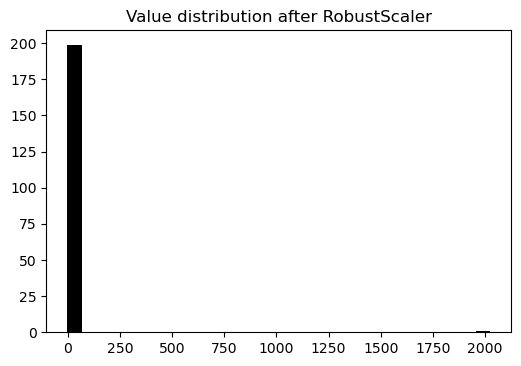

In [35]:
from sklearn.preprocessing import RobustScaler
X_new3 = RobustScaler().fit_transform(X)

# Third column for example (all were scaled)
plt.hist(X_new3[:, 2], bins=30)
plt.title("Value distribution after RobustScaler")
plt.savefig("img/(Ch05)Value distribution after RobustScaler.png")

A stronger approach we can use is to rigorously scale values so that they fall *exclusively* within quantiles.  In essence, this scales the data within each quantile range separately, and hence imposes both reasonable distribution overall and strict bounds on values.

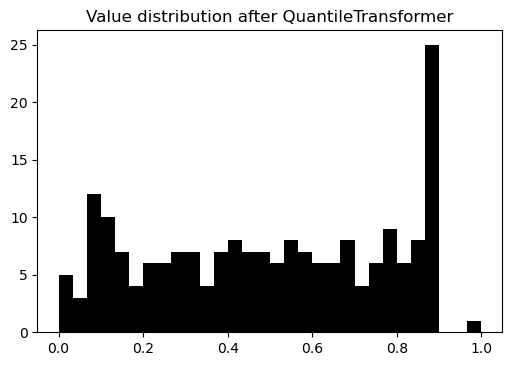

In [36]:
from sklearn.preprocessing import QuantileTransformer
# Ten quantiles is also called "decile"
deciles = QuantileTransformer(n_quantiles=10)
X_new4 = deciles.fit_transform(X)

# Third column for example (all were scaled)
plt.hist(X_new4[:, 2], bins=30)
plt.title("Value distribution after QuantileTransformer")
plt.savefig("img/(Ch05)Value distribution after QuantileTransformer.png")

Obviously this transformed data is not completely uniform—it would have little value if there was not *some* variability beyond ordinal order—but it is bounded and reasonably evenly distributed across the range [0, 1].  The single outlier point remains as a minor outlier from the main distribution, but numerically not very distant.

In principle, even though the specific transformers in scikit-learn operate in a column-wise fashion, we might wish to apply different scaling technique to each column or feature.  As long at the particular transformation generates numeric ranges among the transformed values on roughly the same scale (i.e. usually of about distance one or two between maximum and minimum value, at least for the majority of data), all machine learning techniques that utilize distance in parameter space as part of their algorithm will be satisfied.  Examples of algorithms utilizing distance in parameter space include linear models, support vector machines, and k-nearest neighbor. As was mentioned, algorithms in the family of decision trees simply do not care about specific distance in a dimension, and neural networks can perform a kind of scaling by allowing what we can informally call a "scaling layer" that at least *might* act as a multiplier of each input feature (exactly what a trained network "decides" to use neurons and layers for is always somewhat opaque to our intentions or understanding).

### Factor and Sample Weighting

There are times when you will wish to give a particular feature more significance than *fair scaling* across features allots.  This is a slightly different issue than the one addressed by sampling in chapter 6 (*Value Imputation*).  In that later chapter, I discuss either undersampling or oversampling to produce more witnesses of minority target classes.  That is certainly a possible approach to balancing classes within a feature rather than a target, but is not usually the best approach.  If nothing else, oversampling across two distinct unbalanced classes has the potential to explode the number of synthetic samples.

In the case of unbalanced feature classes, another approach is available.  We can simply *overweight* minority classes rather than oversample them.  Many machine learning models contain an explicit *hyperparameter* called something like `sample_weight` (the scikit-learn spelling).  Seperately from the sample weights, however, these same model classes will also sometimes have something like `class_weight` as a separate hyperparameter.  The distinction here is exactly the one we have been making: sample weight allows you to overweight (or underweight) specific rows of input data, while class weight allows you to over/underweight specific target class values.

To add more nuance to this matter, we are not restricted to over/underweighting only to address class imbalance.  We can, in fact, apply it for any reason we like.  For example, we may know that certain measurements in our data set are more reliable than others, and wish to overweight those.  Or we may know that getting predictions right for samples with a certain characteristic is more important for task-specific reasons, even while not wishing entirely to discard those samples lacking that characteristic.

Let us return to the Apache log file example to illustrate all of these concerns.  Recall that the processed data looks something like this:

In [37]:
reqs.sample(8, random_state=72).drop('page', axis=1)

hour  minute quad1 quad2 method                              path  \
3347      0       4   172    69    GET              /publish/programming   
2729      9      43   172    69    GET                             /TPiP   
8102      4      16   172    69    GET                    /member/images   
9347      0      48   162   158    GET                   /publish/images   
6323     21      30   162   158    GET       /download/pywikipedia/cache   
2352      0      35   162   158    GET  /download/gnosis/xml/pickle/test   
12728     9       0   162   158    GET                   /download/relax   
12235    19       3   172    69    GET                            /dede2   

       status  
3347      200  
2729      200  
8102      404  
9347      304  
6323      200  
2352      200  
12728     200  
12235     404

We noted that both method and status are highly imbalanced in pretty much the way we expect them to be in a working web server.  The method specifically has this imbalance which we saw plotted above.  The hypothetical task we have in mind is to predict status codes based on the other features of the data set (without actually issuing an HTTP request; which might change based on the current time, for example).

In [38]:
reqs.method.value_counts()

GET     13294
HEAD      109
POST       48
Name: method, dtype: int64

In other words, GET requests are 122 times more common than HEAD requests, and 277 times more common than POST requests.  We may be concerned that this limits our ability to make predictions on the rare class values for the method.  Often our models will simply figure this out for us, but sometimes they will not.  Moreover, although it is a frequently occuring `path`, we have decided that we need our model to be more sensitive to paths of `/TPiP` and so will artificially overweight that by 5x as well.  This overweighting is simply by stipulation of a domain purpose, not inherent to the data.  Notice that in this stipulation, the overweighting has nothing whatsoever to do with the underlying distribution of the feature, but rather is a domain requirement of the underlying purpose of our modeling.

Likewise, we are especially concerned to predict 404 status codes (i.e. enhance the *recall* of this label), but are not necessarily interested in the overall balance of the target.  Instead, we will weight all other outcomes as 1, but weight 404s as 10, for task purposes we have determined before performing modeling.  Let us do all of that in code, in this case using a random forest model from scikit-learn.  Should some row match both the overweighted `path` and an underrepresented `method`, the larger multiplier for the method will take precedence.

In [39]:
# The row index positions for rows to overweight
tpip_rows = reqs[reqs.path == '/TPiP'].index
head_rows = reqs[reqs.method == 'HEAD'].index
post_rows = reqs[reqs.method == 'POST'].index

# Configure the weights in a copy of data frame
reqs_weighted = reqs.copy()
reqs_weighted['weight'] = 1  # Default weight of one
reqs_weighted.loc[tpip_rows, 'weight'] = 5
reqs_weighted.loc[head_rows, 'weight'] = 122
reqs_weighted.loc[post_rows, 'weight'] = 277

# Do not use column page in the model
reqs_weighted.drop('page', axis=1, inplace=True)

# View the configured weights
reqs_weighted.sample(4, random_state=72)

hour  minute quad1 quad2 method                  path  status  weight
3347     0       4   172    69    GET  /publish/programming     200       1
2729     9      43   172    69    GET                 /TPiP     200       5
8102     4      16   172    69    GET        /member/images     404       1
9347     0      48   162   158    GET       /publish/images     304       1

These sample weights are stored on a per-row basis, in other words we have 13,451 of them.  For the example, most are simply weight 1, but they could all be distinct numbers, in concept.  Configuring the weights we wish to use with the target is different.  We *could* leverage the sample weight itself to choose rows with certain target label; however, that approach is unnecessarily clunky and is not usually our preferred approach.  Instead, we simply wish to create a small mapping from label to weight.

In [40]:
target_weight = {code:1 for code in reqs.status.unique()}
target_weight[404] = 10
target_weight

{200: 1, 304: 1, 403: 1, 404: 10, 301: 1, 500: 1, 206: 1}

Here we will create, fit, train, and score a scikit-learn model.  The API will vary if you use some other library, but the concepts will remain the same.  It only take a line to perform a train/test split, as is good practice in real code.  As a minor API detail, we need to encode our string categorical values for this model type, so we will use `OrdinalEncoder`.

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder

# Create the model object with target weights
rfc = RandomForestClassifier(class_weight=target_weight,
                             random_state=0)

# Select and encode the features and target
X = reqs_weighted[['hour', 'minute', 
                   'quad1', 'quad2',
                   'method', 'path']]

# Encode strings as ordinal integers
X = OrdinalEncoder().fit_transform(X)
y = reqs_weighted['status']
weight = reqs_weighted.weight

# Perform the train/test split, including weights
X_train, X_test, y_train, y_test, weights_train, _ = (
     train_test_split(X, y, weight, random_state=1))

# Fit the model on the training data and score it
rfc.fit(X_train, y_train, sample_weight=weights_train)
rfc.score(X_test, y_test)

0.8183169788878977

As with R-squared used in the regression example, 1.0 represents perfect *accuracy*.  Accuracy cannot be less than 0.0 though.

Without more context and analysis, I cannot say whether this model does well or poorly for the intended purpose.  Quite possibly some other model class and/or some better tuned weights would serve the hypothetical purpose better.  The steps in trying those are straightforward, and mostly the same as the code shown. 

We turn now to a difficult but important concept.  Many times we wish to remove expected trends from data to reveal the exceptions to those trends.

## Cyclicity and autocorrelation

> Do I contradict myself?<br/>
> Very well then I contradict myself,<br/>
> (I am large, I contain multitudes.)<br/>–Walt Whitman

**Concepts**:

* Detrending sequential data
* Detected cycles versus a priori domain knowledge
* Expected versus distinctive variability
* Multiple cyclicities
* Autocorrelation

There are times when you expect your data to have periodic behavior within it.  In such cases—especially when multiple overlapping cyclicities exist within sequential data—the deviations from the cyclical patterns can be more informative than the raw values.  Most frequently we see this in association with time series data, of course.  To some degree, this concern falls under the purview of chapter 7 (*Feature Engineering*), and indeed we return there to some of the same concerns, and even to the same data set we discuss here.

As a first step, we would like to be able to recognize and analyze periodicities in our data.  Some of these are intuitively obvious once we have some domain knowedge, but others lurk in the data themselves and not necessarily in our initial intuitions.  For this section, I will utilize a data set collected many years ago by my friend, and occasional co-author, Brad Huntting.  For a period in the past, Brad collected temperatures in and outside his house in Colorado (USA), generally every three minutes.  The data presented here covers a few days less than a year.

Rooms inside the house were regulated by thermostats, the outdoors naturally shows seasonal variation.  Moreover, the data itself is imperfect.  When we return to this data in chapter 7 (*Feature Engineering*), we will look at gaps, recording errors, and other problems in the data collection.  For the purpose of this section, a minor degree of data cleanup and value imputation was performed in the code that loads the data set.  See also chapter 6 (*Value Imputation*) for additional discussion of imputation generally, with different examples.

First, let us read in the data using a Python function that loads a Pandas DataFrame.  However, beyond the loading step, we will perform the analysis and visualization in R and its Tidyverse.  Feel free to skim past the detail of the ggplot2 API shown, those are not the lesson of this section, but are merely needed to render plots in book-friendly form.  Very similar capabilities exist in other libraries and languages, including Pandas.  The underlying concepts are important here, not the specific APIs and languages used.  Brad uses a web domain name of "glarp" so we use that same invented word for some variable names referring to this data about his house temperatures.

In [42]:
thermo = read_glarp()
start, end = thermo.timestamp.min(), thermo.timestamp.max()
print("Start:", start)
print("  End:", end)
# Fencepost counting includes ends
print(" Days:", 1 + (end.date() - start.date()).days)

Start: 2003-07-25 16:04:00
  End: 2004-07-16 15:28:00
 Days: 358


Let us look at a few rows of the data set to have a feeling for its nature.  We can see that one row exists every three minutes during the interval of recording.  For this section, the interval is completely regular at 3 minutes, and no missing values are present.  Moreover, a few obvious recording errors in the raw data are cleaned up here with imputed values.

In [43]:
%%R -i thermo
glarp <- as.tibble(thermo)
glarp

# A tibble: 171,349 x 5
   timestamp           basement   lab livingroom outside
   <dttm>                 <dbl> <dbl>      <dbl>   <dbl>
 1 2003-07-25 16:04:00     24    25.2       29.8    27.5
 2 2003-07-25 16:07:00     24    25.2       29.8    27.3
 3 2003-07-25 16:10:00     24    25.2       29.8    27.3
 4 2003-07-25 16:13:00     24.1  25.2       29.8    27.4
 5 2003-07-25 16:16:00     24.1  25.2       29.8    27.8
 6 2003-07-25 16:19:00     24.1  25.2       29.8    27.5
 7 2003-07-25 16:22:00     24.1  25.2       29.8    27.6
 8 2003-07-25 16:25:00     24.1  25.2       29.8    27.6
 9 2003-07-25 16:28:00     24.1  25.2       29.8    27.7
10 2003-07-25 16:31:00     24.1  25.2       29.8    27.6
# … with 171,339 more rows


We can visualize this data as a first step to removing cyclicities with the goal of focusing on the ways in which individual measurements vary from *expectations*.  These operations are also called "detrending" the data.  Let us look first at outside temperatures.

Below I define visual themes that will be used for the plots in this section.

In [44]:
%%R
clean_theme <- theme(
    panel.background = element_blank(),
    panel.grid.major.y = element_line(
        color = "gray", size = 0.25, linetype = "dotted"),
    axis.title.x = element_blank())

no_xlabel <- clean_theme + theme(
    axis.title.x = element_blank(),
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    plot.margin = unit(c(0, -1, -1, 0), "cm"))

First, let us plot the pattern of outside temperatures.

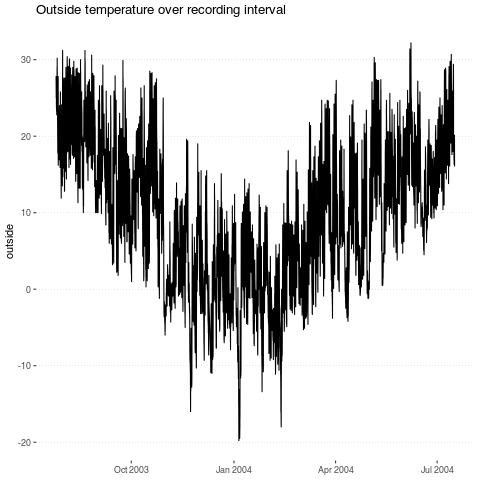

In [45]:
%%R
im <- ggplot(glarp, aes(x=timestamp, y=outside)) +
  geom_line() + clean_theme +
  ggtitle("Outside temperature over recording interval")
im

In [46]:
%%capture --no-stdout err
%%R
ggsave("img/(Ch05)Outside temperature over recording interval.png", dpi=600)

As is easy to guess, there is a general pattern of northern hemisphere temperatures being warmer in July than in January, with a great deal of jitter within the global trend.  Even though only one year of data is available, we know from very basic domain knowledge to expect similar annual cycles for other years. In contrast, as we can also anticipate, indoor temperatures both fall within a narrower range and show less of a clear pattern.

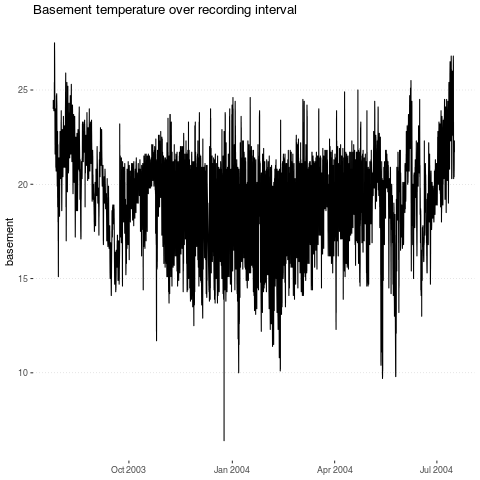

In [47]:
%%R
im <- ggplot(glarp, aes(x=timestamp, y=basement)) +
  geom_line() + clean_theme +
  ggtitle("Basement temperature over recording interval")
im

In [48]:
%%capture --no-stdout err
%%R
ggsave("img/(Ch05)Basement temperature over recording interval.png", dpi=600)

Overall, indoor temperatures in the basement are relatively narrowly bound between about 14℃ and 23℃.  Some points fall outside of this range, both some high summer temperatures indicating that the house had a heating system but no air conditioner, and some low winter temperatures in sharp spikes, perhaps reflecting periods when windows were opened.  However, the outside lows reached about -20℃ while these indoor lows are generally above 10℃.  Something somewhat odd seems to have happened around September and October of 2003 as well; perhaps this reflects some change in the heating system during that period.

### Domain Knowledge Trends

As a first task, let us think about outdoor temperatures that are presumably little affected by the house heating system.  We would like to identify unexpectedly warm or unexpectedly cold measurements as inputs to our downstream model.  For example, a temperature of 10℃ might either be a surprisingly cold summer temperature or a surprisingly warm winter temperature, but in itself it is merely globally typical and does not carry very much information about the observation without additional context.

Given that yearly temperatures will continue to repeat from year to year, it might make sense to model this yearly pattern as a portion of a sine wave.  However, in shape it certainly resembles a parabola for this period from roughly the warmest day of 2003 until roughly the warmest day of 2004.  Since we are merely detrending a year-scale pattern, not *modeling* the behavior, let us fit a second order polynomial to the data, which will account for *most* of the variation that exists in the measurements.

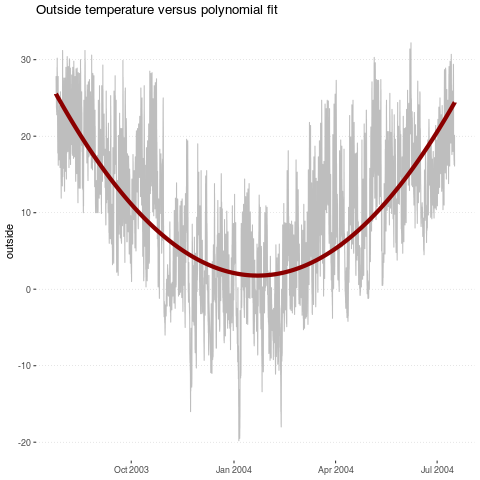

In [49]:
%%R
# Model the data as a second order polynomial
year.model <- lm(outside ~ poly(timestamp, 2), data = glarp)

# Display the regression and the data
im <- ggplot(glarp, aes(x=timestamp)) + clean_theme +
  geom_line(aes(y = outside), color = "gray") +
  geom_line(aes(y = predict(year.model)), 
            color = "darkred", size = 2) +
  ggtitle("Outside temperature versus polynomial fit") 
im

In [50]:
%%capture --no-stdout err
%%R    
ggsave("img/(Ch05)Outside temperature versus polynomial fit.png", dpi=600)

We can see in the plot that our annual detrending accounts for most of the data variation, so we can simply subtract the trend from the underlying points to get, as a first pass, the degree to which a measurement is unexpected.  A new tibble named `outside` will hold the data for this narrower focus.

In [51]:
%%R
outside <- glarp[, c("timestamp", "outside")] %>%
    add_column(no_seasonal = glarp$outside - predict(year.model))
outside

# A tibble: 171,349 x 3
   timestamp           outside no_seasonal
   <dttm>                <dbl>       <dbl>
 1 2003-07-25 16:04:00    27.5        1.99
 2 2003-07-25 16:07:00    27.3        1.79
 3 2003-07-25 16:10:00    27.3        1.79
 4 2003-07-25 16:13:00    27.4        1.89
 5 2003-07-25 16:16:00    27.8        2.29
 6 2003-07-25 16:19:00    27.5        1.99
 7 2003-07-25 16:22:00    27.6        2.10
 8 2003-07-25 16:25:00    27.6        2.10
 9 2003-07-25 16:28:00    27.7        2.20
10 2003-07-25 16:31:00    27.6        2.07
# … with 171,339 more rows


Visualizing the seasonally detrended temperatures, we see a remaining range from around -20℃ to +20℃.  This is somewhat less than the range of the raw temperatures, but only somewhat.  Variability has decreased, but only modestly.  However, there is no obvious overall annual trend once we have performed this removal, and the synthetic value is centered at zero.

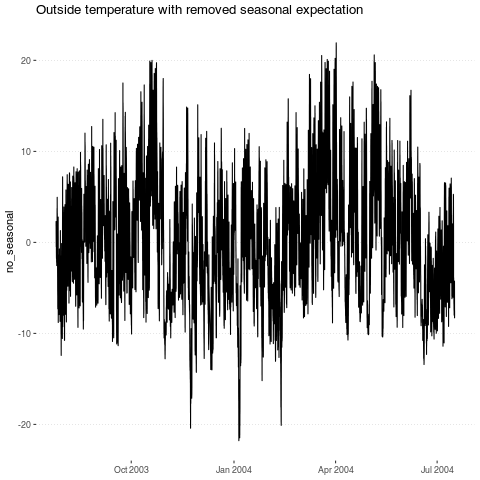

In [52]:
%%R
im <- ggplot(outside, aes(x=timestamp)) +
  geom_line(aes(y = no_seasonal)) + clean_theme +
  ggtitle("Outside temperature with removed seasonal expectation")
im

In [53]:
%%capture --no-stdout err
%%R
ggsave("img/(Ch05)Outside temperature with removed seasonal expectation.png", dpi=600)

The second obvious insight we might have into outdoor temperature cycles is that it is warmer during the day than at night.  Given that there are 358 days of data, a polynomial will clearly not fit, but a trigonometric model is likely to fit to a better degree.  We do not calculate a Fourier analysis here, but rather simply look for an expected daily cyclicity.  Since we have observations every 3 minutes during each day, we wish to convert these 3360 intervals into $2\pi$ radians for the regression to model.  The model will simply consist of fitted sine and cosine terms which can additively construct any sine-like curve on the specified periodicity.

In [54]:
%%R
# Make one day add up to 2*pi radians
x <- 1:nrow(outside) * 2*pi / (24*60/3)
    
# Model the data as a first order trigometric regression
day_model <- lm(no_seasonal ~ sin(x) + cos(x), 
                data = outside)
print(day_model)

# Create a new tibble the holds the regression 
# and its removal from the annually detrended data
outside2 <- add_column(outside, 
                day_model = predict(day_model),
                no_daily = outside$no_seasonal - day_model)
outside2


Call:
lm(formula = no_seasonal ~ sin(x) + cos(x), data = outside)

Coefficients:
(Intercept)       sin(x)       cos(x)  
  0.0002343   -0.5914551    3.6214463  

# A tibble: 171,349 x 5
   timestamp           outside no_seasonal day_model no_daily
   <dttm>                <dbl>       <dbl>     <dbl>    <dbl>
 1 2003-07-25 16:04:00    27.5        1.99      3.61    -1.62
 2 2003-07-25 16:07:00    27.3        1.79      3.60    -1.81
 3 2003-07-25 16:10:00    27.3        1.79      3.60    -1.80
 4 2003-07-25 16:13:00    27.4        1.89      3.59    -1.69
 5 2003-07-25 16:16:00    27.8        2.29      3.58    -1.28
 6 2003-07-25 16:19:00    27.5        1.99      3.56    -1.57
 7 2003-07-25 16:22:00    27.6        2.10      3.55    -1.46
 8 2003-07-25 16:25:00    27.6        2.10      3.54    -1.44
 9 2003-07-25 16:28:00    27.7        2.20      3.53    -1.33
10 2003-07-25 16:31:00    27.6        2.07      3.51    -1.44
# … with 171,339 more rows


It is difficult to tell from just the first few rows of the data frame, but the daily detrending is typically closer to zero than is the seasonal detrending alone.  The regression consists mostly of a cosine factor, but is shifted a bit by a smaller negative sine factor.  The intercept is very close to zero, as we would expect from the seasonal detrending.  If we visualize the three lines we can get some sense; in order to show it better, only one week in early August of 2003 is shown.  Other time periods have a similar pattern; all will be centered at zero because of the detrending.  

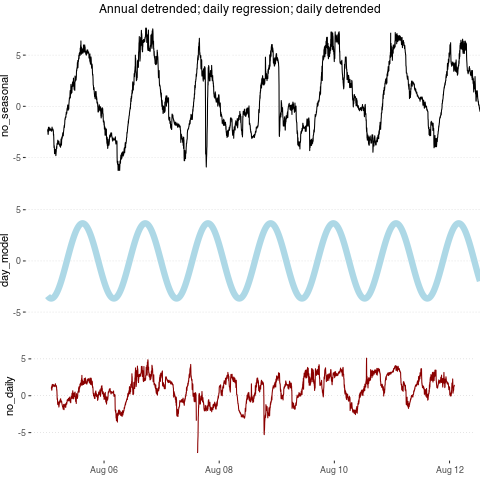

In [55]:
%%R
week <- outside2[5000:8360,]
p1 <- ggplot(week, aes(x = timestamp)) +
  no_xlabel + ylim(-8, +8) + 
  geom_line(aes(y = no_seasonal))
p2 <- ggplot(week, aes(x = timestamp)) +
  no_xlabel + ylim(-8, +8) + 
  geom_line(aes(y = day_model), color = "lightblue", size = 3)
p3 <- ggplot(week, aes(x = timestamp)) +
   clean_theme + ylim(-8, +8) +
  geom_line(aes(y = no_daily), color = "darkred")
grid.arrange(p1, p2, p3,
            top = "Annual detrended; daily regression; daily detrended")

In [56]:
%%capture --no-stdout err
%%R
ggsave("img/(Ch05)Annual detrended.png", plot=p1, dpi=600)
ggsave("img/(Ch05)Daily regression.png", plot=p2, dpi=600)
ggsave("img/(Ch05)Daily detrended.png", plot=p3, dpi=600)

The thicker smooth line is the daily model of temperature.  In electronic versions of this book, it will appear as light blue.  At top is the more widely varying seasonally detrended data. At bottom, the daily detrended data has mostly lower magnitudes (in red if your reading format allows it).  The third subplot is simply the subtraction of the middle subplot from the top one.

Around August 7 are some oddly low values.  These look sharp enough to suggest data problems, but perhaps a thunderstorm brought August temperatures that much lower during one afternoon.  One thing we can note in the date range plotted is that even the daily detrended data shows a weak daily cycle, albeit with much more noise.  This would indicate that other weeks of the year have less temperature fluctuation than this one; in fact, some weeks will show an anti-cyclic pattern with the detrended data being an approximate inverse of the regression line. Notably, even on this plot, it looks like August 8 was anti-cyclic, while August 5 and 6 have a remaining signal matching the sign of the regression, and the other days have a less clear correspondence.  By anti-cyclic, we do not mean that, e.g. a night was warmer than the days around it, but rather that there was less than the expected fluctuation, and hence detrending produces an inverted pattern.

That said, while we have not removed every possible element of more complex cyclic trends, the range of most values in the doubly detrended data is approximately 8℃ whereas it was approximately 50℃ for the raw data.  Our goal is not to remove the underlying variability altogether but rather to emphasize the more extreme magnitude measurements, which this has done.

### Discovered Cycles

We have good a priori beliefs about what outdoor temperatures are likely to do.  Summers are warmer than winters, and nights are colder than days.  However, no similarly obvious assumption presents itself for indoor temperatures.  We saw earlier a plot for temperatures in Brad's basement. The data is interestingly noisy, but in particular we noticed that for about two summer months, the basement temperatures were pinned above about 21℃ throughout the day and night.  From this, we inferred that Brad's house had a heating system but no cooling system, and therefore the indoor temperature approximately followed the higher outdoor ones.  We wish here to analyze only the heating system, and its artificially maintained temperature, rather than the seasonal trend. Let us limit the data to non-summer days (here named according to the pattern in the data rather than the official season dates).

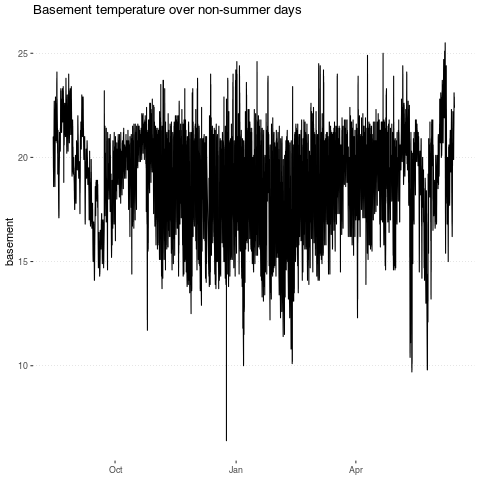

In [57]:
%%R
not_summer <- filter(glarp, 
                     timestamp >= as.Date("2003-08-15"), 
                     timestamp <= as.Date("2004-06-15")) 

# Plot only the non-summer days
im <- ggplot(not_summer, aes(x=timestamp, y=basement)) +
  geom_line() + clean_theme +
  ggtitle("Basement temperature over non-summer days")
im

In [58]:
%%capture --no-stdout err
%%R
ggsave("img/(Ch05)Basement temperature over non-summer days.png", plot=im, dpi=600)

Within the somewhat narrowed period, nearly every day of measurements has temperatures both above and below around 18-20℃, so most likely the heating system was operating for a portion of each day in almost all of these non-summer days.  The question we would like to analyze—and perhaps to detrend—is whether cyclic patterns exist in indoor temperature data, amongst the considerable noisiness that is clearly present in the raw data.

A technique called *autocorrelation* lends itself well to this analysis. Autocorrelation is a mathematical technique that identifies repeating patterns, such as the presence of a periodic signal mixed with noise or non-periodic variation.  In Pandas, the Series method `.autocorr()` looks for this.  In R, the relevant function is called `acf()`.  Other libraries or programming languages have similar capability.  Let us take a look at what we discover.  We do not wish blindly to look for autocorrelations if our domain knowledge tells us that only certain periodicities "make sense" within the subject matter.

Although our data frame contains a `timeseries` column already, it is easier here simply to create one out of the `basement` column we will work with.  The actual dates corresponding to data points are irrelevant for the operation; only their spacing in time is of interest. In particular, we can impose a frequency matching the number of observations in a day to get a plot labeled intuitively by number of days.  The `acf()` function generates a plot automatically, and returns an object with a number of values attached you can utilize numerically.  For purpose of this section, the graph is sufficient.

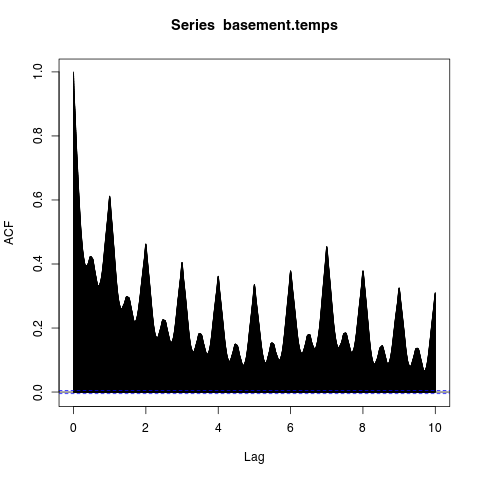

In [59]:
%%R
per_day <- 24*60/3
basement.temps <- ts(not_summer$basement, frequency = per_day)
auto <- acf(basement.temps, lag.max = 10*per_day)

In [60]:
%%capture --no-stdout err
%%R
png("img/(Ch05)basement.temps ACF.png", width=1200, height=800)
plot(auto)

Trivially, the zero increment is 100% correlated with itself.  As the autocorrelation name suggests, this show the correlation of the single data series with itself at each possible offset.  Everything other than that tells us something specific about the cyclicities within this particular data.  There are strong spikes at each integral number of days.  We limited the analysis to 10 days forward here.  These spikes let us see that the thermostat in the basement had a setting to regulate the temperature to different levels at different times of each day, but in a way that was largely the same between one day and each of the next ten after it.

The spikes in this data are sloped rather than sharp (they are, at least, continuous rather than stepped).  Any given 3-minute interval tends to have a similar temperature to those nearby it, diminishing fairly quickly, but not instantaneously, as measurements occur farther away.  This is what we would expect in a house with a thermostat-controlled heating system, of course.  Other systems might be different; for example, if a light was on a timer to come on for exactly 3 minutes then go out, on some schedule, the measurement of light levels would be suddenly, rather than gradually, different between adjacent measurements.

The pattern in the autocorrelation provides more information than only the daily cycle, however.  We see also a lower correlation at approximately half-day intervals.  This is also easily understood by thinking about the domain and the technology that produced it.  To save energy, Brad set his thermostat timer to come on in mornings when he wakes up, then go to a lower level while he was at an office, then again to go up in the early evening when he returns home.  I happen to know this was an automated setting, but the same effect might, for example, have occurred if it was simply a human pattern of manually adjusting the thermostat up and down at those times (the signal would probably be less strong than with a mechanical timer, but likely present).

Rising above the daily cyclicity there is also a somewhat higher spike in the autocorrelation at 7 days.  This indicates that days of the week are correlated with the temperature setting of the thermostat.  Most likely, either because of a timer setting or human habit and comfort, a different temperature was set on weekdays versus weekends, for example.  This secondary pattern is less strong than the general 24-hour cyclicity, but about as strong as the half-day cyclicity; examining the autocorrelation spikes more carefully could reveal exactly what duration Brad was at his office versus coming home, typically.  The offset of the secondary spikes from the 24-hour spikes is probably not at exactly 12-hours, but is at some increment less than the full 24-hours.

We will not do these operations in this section, but think about using the autocorrelation as a detrending regression, much as we did with the trigonometric regression.  This would effectively have separate periodicities of 12- and 24-hours, and at 7 days.  Clearly the raw data shown has a lot of additional noise, but it would presumably be reduced by subtracting out these known patterns.  Some very atypical values would stand out even more strongly among this detrended data, and potentially thereby have even stronger analytic significance.

Sometimes the data validation that we need to perform is simply highly specific to the domain in question.  For that, we tend to need more custom approaches and code.

## Bespoke validation

> Explanations exist; they have existed for all time; 
> there is always a well-known solution to every human 
> problem—neat, plausible, and wrong.<br/>–H. L. Mencken

**Concepts**:

* Leveraging domain knowledge beyond anomaly detection
* Example: evaluating duplicated data
* Validation as sanity check to further investigation

There are many times when domain knowledge informs the shape of data that is likely to be genuine versus data that is more likely to reflect some kind of recording or collation error.  Even though general statistics on the data do not show anomalies, bias, imbalance, or other generic problems, we know something more about the domain or the specific problem that informs our expectations about "clean" data.

To illustrate, we might have an expectation that certain kinds of observations should occur with roughly a particular frequency compared to other observations; perhaps this would be specified further by the class values of a third categorical variable.  For example, as background domain knowledge, we know that in the United States, family size is slightly less than 2 children, on average.  If we had data that was meant to contain information about all the individual people in sampled households, we could use this as a guideline for the shape of the data.  In fact, if we had auxiliary data on children-per-household by state, we might refine this reference expectation more in validating our data.

Obviously, we do not expect every household to have exactly 1.9 children in it.  Given that humans come in integral units, we in fact could never have such a fractional number in any specific household at all.  However, if we found that in our sampled households we averaged 0.5 children per household, or 4 children per household-with-children, we would have a strong indication that some kind of sample bias was occurring.  Perhaps children are under- or overreported in the household data for individual households.  Perhaps the selection of which households to sample biases the data towards those with children, or towards those without them.  This scenario is largely similar to the issue addressed earlier in this chapter of comparisons to baselines. It adds only a minor wrinkle to the earlier examples in that we only identify households where we wish to validate our expectation of number of children (i.e. under 18 years old) based on a shared address feature across several observations (that is, a household).

### Collation Validation

Let us look at a completely different example that really cannot be formulated in terms of baseline expectations.  For this section, we consider genomic data on ribosomal RNA that was downloaded from DNA Data Bank of Japan, specifically the [16S rRNA (Prokaryotes) in FASTA format](ftp://ftp.ddbj.nig.ac.jp/ddbj_database/16S/) data set. You do not need to know anything about genomics or cellular biology for this example; we focus simply on the data formats used and an aggregation of records in this format.

Each sequence in this data set contains a description of the organism in question and the nature of the sequence recorded.  The FASTA format is widely used in genomics and is a simple textual format.  Multiple entries in the line-oriented format can simply be concatenated in the same file or text. For example, a sequence entry might look like this:

```FASTA
>AB000001_1|Sphingomonas sp.|16S ribosomal RNA
agctgctaatattagagccctatatatagagggggccctatactagagatatatctatca
gctaatattagagccctatatatagagggggccctatactagagatatatctatcaggct
attagagccctatatatagagggggccctatactagagatataagtcgacgatattagca
agccctatatatagagggggccctatactagagatatatctatcaggtgcacgatcgatc
cagctagctagc
```

The description published with this data set indicates that each sequence contained is at least 300 base pairs, and the average length is 1,104 base pairs.  Note that in DNA or RNA, every nucleobase uniquely determines which other base is paired in a double helix, so the format does not need to notate both. There are 998,911 sequences contained as of this writing.  A variety of high-quality tools exist for working with genomic data; details of those are outside the scope of this book.  However, as an example, let us use **SeqKit** to identify duplicated sequences.  In this data set, there are no pairs of sequences with the same name or ID, but quite a few contain the same base pairs.  This is not an error, per se, since it reflects different observations.  It may, however, be redundant data that is not useful for our analysis.

In [61]:
%%bash
cd data/prokaryotes
zcat 16S.fasta.gz | 
  seqkit rmdup --by-seq --ignore-case \
               -o clean.fasta.gz \
               -d duplicated.fasta.gz \
               -D duplicated.detail.txt

[INFO] 159688 duplicated records removed


Around 15% of all the sequences are duplicates.  In general these are multiple IDs that pertain to the same organism.  We can see such in a quick examination of the duplication report produced by `seqkit`.  As an exercise, you might think about how you would write a similar duplicate detection function in a general purpose programming language; it is not particularly difficult, but SeqKit is certainly more optimized and better tested than would be a quick implementation you might produce yourself.

In [62]:
%%bash
cut -c-60 data/prokaryotes/duplicated.detail.txt | head

1384	JN175331_1|Lactobacillus, MN464257_1|Lactobacillus, MN4
1383	MN438326_1|Lactobacillus, MN438327_1|Lactobacillus, MN4
1330	AB100791_1|Lactococcus, AB100792_1|Lactococcus, AB10079
1004	CP014153_1|Bordetella, CP014153_2|Bordetella, CP014153_
934	MN439952_1|Lactobacillus, MN439953_1|Lactobacillus, MN43
912	CP003166_2|Staphylococcus, CP003166_3|Staphylococcus, CP
908	CP010838_1|Bordetella, CP010838_2|Bordetella, CP010838_3
793	MN434189_1|Enterococcus, MN434190_1|Enterococcus, MN4341
683	CP007266_3|Salmonella, CP007266_5|Salmonella, CP007266_6
609	MN440886_1|Leuconostoc, MN440887_1|Leuconostoc, MN440888


Horizontal transfer of rRNA between organisms is possible, but such an occurrence in the data might also represent a misclassification of an organism under examination. We can write some code to determine if such an event of multiple IDs for the same sequence sometimes are tagged as different bacteria (or perhaps archaea).

In [63]:
def matched_rna(dupfile):
    """Count of distinct organisms per sequence match
    
    Return a mapping from line number in the duplicates
    to Counters of occurrences of species names
    """
    counts = dict()
    for line in open(dupfile):
        line = line.rstrip()
        _, match_line = line.split('\t')
        matches = match_line.split(', ')
        first_id = matches[0].split('|')[0]
        names = [match.split('|')[1] for match in matches]
        count = Counter(names)
        counts[first_id] = count
    return counts

It turns out that cataloging multiple organisms with apparently identical rRNA sequences is quite a common occurrence.  But our analysis/validation may shed light on what is likely occurring with these duplicate records.  Many lines in the duplication report show just one species with many observations.  A significant minority show something else.  Let us look at several examples.

In [64]:
dupfile = 'data/prokaryotes/duplicated.detail.txt'
counts = matched_rna(dupfile)

In some examples, different observations have differing levels of specificity, but are not per se different organisms. 

In [65]:
print(counts['CP004752_1'])
print(counts['AB729796_1'])

Counter({'Mannheimia': 246, 'Pasteurellaceae': 1})
Counter({'Microbacterium': 62, 'Microbacteriaceae': 17})


Mannheimia is a genus of the family Pasteurellaceae, and Microbacterium is a genus of the family Microbacteriaceae.  Whether these "discrepencies" need to be remediated in cleanup is very problem specific, however.  For example, we may wish to use the more general families in order to group matching sequences together.  On the other hand, the problem may demand as much specificity in identifying organisms as is available.  You have to decide how to process or handle different levels of specificity in your domain ontology.

A similar issue occurs in another record, but with what appears to be an additional straightforward data error. 

In [66]:
counts['AB851397_1']

Counter({'Proteobacteria': 1, 'proteobacterium': 2, 'Phyllobacteriaceae': 8})

Phyllobacteriaceae is a family in the broad phylum Proteobacteria, so either way we are dealing with rather non-specific classification.  But 'proteobacterium' appears to be a non-standard way of spelling the Linnaean family, both in being singular and in lack of capitalization of the name.

Looking at another record, we might judge the classification as an observational error, but it is obviously difficult to be certain without deeper domain knowledge.

In [67]:
counts['CP020753_6']

Counter({'Shigella': 11, 'Escherichia': 153})

Both Shigella and Escherichia belong to the family Enterobacteriaceae.  The identical sequence is characterized as belonging to different genera here.  Whether this indicates a misidentification of the underlying organism or a horizontal transfer of rRNA between these organisms is not clear from this data alone.  However, in your data science task, this is the sort of decision you are required to make, probably in consultation with domain experts.

One more record we can look at is very strange relative to this data set.  It shows many duplicates, but that is not really the surprising aspect.

In [68]:
counts['FJ537133_1']

Counter({'Aster': 1,
         "'Elaeis": 1,
         "'Tilia": 1,
         "'Prunus": 2,
         "'Brassica": 3,
         'Papaya': 1,
         "'Phalaris": 1,
         "'Eucalyptus": 1,
         "'Melochia": 1,
         'Chinaberry': 1,
         "'Catharanthus": 4,
         "'Sonchus": 1,
         "'Sesamum": 1,
         'Periwinkle': 1,
         'Candidatus': 1})

In this case, we have a number of genera of flowering plants—that is, eukaryotes—mixed with a data set that is documented to catalog rRNA in prokaryotes.  There is also a spelling inconsistency in that many of the genera listed have a spurious single quote character at the beginning of their name.  Whether or not it is plausible for these different plants, mostly trees, to share rRNA is a domain knowledge question, but it seems likely that these data do not belong within our hypothetical analysis of prokaryotic rRNA at all.

The examination of duplicated sequences in this data set of rRNA sequences points to a number of likely problems in the collection.  It also hints at problems that may lurk elsewhere within the collection.  For example, even where identical sequences are not named by different levels of cladistic phylogeny, these differing levels may conflate the classification of other sequences.  Perhaps, for example, this calls out for normalization of the data to a common phyletic level (which is a significantly large project, but it might be required for a task).  Either way, this cursory validation suggests a need to filter the data set to address only a well-defined collection of genera or families of organisms.

### Transcription Validation

We discussed above, in this section, the possibility that the collection of records (i.e. sequences) may have problems in their annotation or aggregation.  Perhaps records are inconsistent with each other or in some way present conflicting information.  The examples we identified point to possible avenues for removal or remediation.  In this second part of the section we want to look at possible identifiable errors in the individual records.

This hypothetical is presented simply as a data example, not per se motivated by deep knowledge of RNA sequencing techniques.  This is commonly the perspective of data scientists who work with domain experts.  For example, I do not know how many of the measurements in the data set utilized RNA-Seq versus older hybridization-based microarrays.  But for this purpose, let us suppose that a relatively common error in the sequencing technique causes inaccurate repetitions of short fragments of RNA base pairs that are not present in the actual measured rRNA.  On the other hand, we also do know that microsatellites and minisatellites *do occur* in rRNA as well (although telomeres do not), so the mere presence of repeated sequences does not prove that a data collection error occurred, it is merely suggestive.

The purpose of this example is simply to present the idea that something as custom as what we do below *may* be relevant to your data validation for your specific domain.  What we will look for is all the places where relatively long subsequences are repeated within a particular sequence.  Whether this is an error or an interesting phenomenon is a matter for domain expertise.  By default in the code below we look for repeated subsequences of 45 base pairs, but provide a configuration option to change that length.  If each nucleotide were simply randomly chosen, each particular pattern of length 45 would occur with probability of about $10^{-27}$, and repetitions—even with "birthday paradox" considerations—would essentially never occur.  But genetic processes are not so random as that.

As a first step, let us create a short function that iterates over a FASTA file, producing a more descriptive namedtuple for each sequence contained along with its metadata.  Many libraries will do something similar, perhaps faster and more robustly than the code shown does, but the FASTA format is simple enough that such a function is simple to write.

In [69]:
Sequence = namedtuple("FASTA", "recno ID name locus bp")

def get_sequence(fname):
    fasta = gzip.open(fname)
    pat = re.compile(r'n+')
    sequence = []
    recno = 0
    for line in fasta:
        line = line.decode('ASCII').strip()
        if line.startswith('>'):
            # Modify base pairs to contain single '-' 
            # rather than strings of 'n's 
            bp = "".join(sequence)
            bp = re.sub(pat, '-', bp)
            if recno > 0:
                yield Sequence(recno, ID, name, locus, bp)
            ID, name, locus = line[1:].split('|')
            sequence = []
            recno += 1
        else:
            sequence.append(line)

The `get_sequence()` function allows us to iterate lazily over all the sequences contained in a single gzipped file.  Given that the total data is 1.1GiB, not reading it all at once is an advantage.  Beyond assuming such files are gzipped, it also makes an assumption that headers are formatted in the manner of the DDBJ rather than according to a different convention or lacking headers.  As I say, other tools are more robust.  Let us try reading just one record to see how the function works:

In [70]:
fname = 'data/prokaryotes/16S.fasta.gz'
prokaryotes = get_sequence(fname)
rec = next(prokaryotes)

print(rec.recno, rec.ID, rec.name, rec.locus)
print(fill(rec.bp, width=60))

1 AB000106_1 Sphingomonas sp. 16S ribosomal RNA
ggaatctgcccttgggttcggaataacgtctggaaacggacgctaataccggatgatgac
gtaagtccaaagatttatcgcccagggatgagcccgcgtaggattagctagttggtgagg
taaaggctcaccaaggcgacgatccttagctggtctgagaggatgatcagccacactggg
actgagacacggcccagactcctacgggaggcagcagtagggaatattggacaatgggcg
aaagcctgatccagcaatgccgcgtgagtgatgaaggccttagggttgtaaagctctttt
acccgggatgataatgacagtaccgggagaataagccccggctaactccgtgccagcagc
cgcggtaatacggagggggctagcgttgttcggaattactgggcgtaaagcgcacgtagg
cggcgatttaagtcagaggtgaaagcccggggctcaaccccggaatagcctttgagactg
gattgcttgaatccgggagaggtgagtggaattccgagtgtagaggtgaaattcgtagat
attcggaagaacaccagtggcgaaggcggatcactggaccggcattgacgctgaggtgcg
aaagcgtggggagcaaacaggattagataccctggtagtccacgccgtaaacgatgataa
ctagctgctggggctcatggagtttcagtggcgcagctaacgcattaagttatccgcctg
gggagtacggtcgcaagattaaaactcaaaggaattgacgggggcctgcacaagcggtgg
agcatgtggtttaattcgaagcaacgcgcagaaccttaccaacgtttgacatccctagta
tggttaccagagatggtttccttcagttcggctggctaggtgacaggtgctgcatggctg
tcgtcagctcgtgtcgtgagatgttgggttaagtccc

In order to check each sequence/record for the subsequence duplication we are concerned about, another short function can help us.  This Python code uses a Counter again, as did the `matched_rna()` function earlier.  It simply looks at every subsequence of a given length, many thereby overlapping, and returns only those counts that are greater than 1.

In [71]:
def find_dup_subseq(bp, minlen=45):
    count = Counter()
    for i in range(len(bp)-minlen):
        count[bp[i:i+minlen]] += 1
    return {seq: n for seq, n in count.items() if n > 1}

Putting it together, let us look at only the first 2,800 records to see if any have the potential problem we are addressing.  Given that the full data set contains close to one million sequences, many more such duplicates occur.  An initial range was only chosen by trial-and-error to find exactly two examples.  Duplicate subsequences are comparatively infrequent, but not so rare as not to occur numerous times among a million sequences.

In [72]:
for seq in islice(get_sequence(fname), 2800):
    dup = find_dup_subseq(seq.bp)
    if dup:
        print(seq.recno, seq.ID, seq.name)
        pprint(dup)

2180 AB051695_1 Pseudomonas sp. LAB-16
{'gtcgagctagagtatggtagagggtggtggaatttcctgtgtagc': 2,
 'tcgagctagagtatggtagagggtggtggaatttcctgtgtagcg': 2}
2534 AB062283_1 Acinetobacter sp. ST-550
{'aaaggcctaccaaggcgacgatctgtagcgggtctgagaggatga': 2,
 'aaggcctaccaaggcgacgatctgtagcgggtctgagaggatgat': 2,
 'accaaggcgacgatctgtagcgggtctgagaggatgatccgccac': 2,
 'aggcctaccaaggcgacgatctgtagcgggtctgagaggatgatc': 2,
 'ccaaggcgacgatctgtagcgggtctgagaggatgatccgccaca': 2,
 'cctaccaaggcgacgatctgtagcgggtctgagaggatgatccgc': 2,
 'ctaccaaggcgacgatctgtagcgggtctgagaggatgatccgcc': 2,
 'gcctaccaaggcgacgatctgtagcgggtctgagaggatgatccg': 2,
 'ggcctaccaaggcgacgatctgtagcgggtctgagaggatgatcc': 2,
 'ggggtaaaggcctaccaaggcgacgatctgtagcgggtctgagag': 2,
 'gggtaaaggcctaccaaggcgacgatctgtagcgggtctgagagg': 2,
 'ggtaaaggcctaccaaggcgacgatctgtagcgggtctgagagga': 2,
 'ggtggggtaaaggcctaccaaggcgacgatctgtagcgggtctga': 2,
 'gtaaaggcctaccaaggcgacgatctgtagcgggtctgagaggat': 2,
 'gtggggtaaaggcctaccaaggcgacgatctgtagcgggtctgag': 2,
 'taaaggcctaccaaggc

As before, this validation only points in the direction of asking domain and problem specific questions, and does not determine the correct action.  Subsequence duplications may indicate errors in the sequencing process, but they might also reveal something relevant about the underlying domain, and genomic mechanisms.  Collisions are far too unlikely to occur by mere chance, however.

## Exercises

For the exercises of this chapter, we first ask you to perform a typical multi-step data cleanup using techniques you have learned.  For the second exercise asks you to try to characterize sample bias in a provided data set using analytic tools this book has addressed (or others of your choosing).

### Data Characterization

For this exercise, you will need to perform a fairly complete set of data cleaning steps.  The focus is on techniques discussed in this chapter, but concepts discussed in other chapters will be needed as well.  Some of these tasks will require skills discussed in later chapters, so skip ahead briefly, as needed, to complete the tasks.

Here we return to the "Brad's House" temperature data, but in its raw form.  The raw data consists of four files, corresponding to the four thermometers that were present.  These files may be found at:

> https://www.gnosis.cx/cleaning/outside.gz<br/>
> https://www.gnosis.cx/cleaning/basement.gz<br/>
> https://www.gnosis.cx/cleaning/livingroom.gz<br/>
> https://www.gnosis.cx/cleaning/lab.gz

The format of these data files is a simple but custom textual format.  You may want to refer back to chapter 1 (*Data Ingestion – Tablar Formats*) and to chapter 3 (*Data Ingestion – Repurposing Data Sources*) for inspiration on parsing the format.  Let us look at a few rows:

In [73]:
%%bash
zcat data/glarp/lab.gz | head -5

2003 07 26 19 28 25.200000
2003 07 26 19 31 25.200000
2003 07 26 19 34 25.300000
2003 07 26 19 37 25.300000
2003 07 26 19 40 25.400000


As you can see, the space separated fields represent the components of a datetime, followed by a temperature reading.  The format itself is consistent for all the files.  However, the specific timestamps recorded in each file is not consistent.  All four data files end on 2004-07-16T15:28:00, and three of them begin on 2003-07-25T16:04:00. Various and different timestamps are missing in each file.  For comparison, we can recall that the full data frame we read with a utility function that performs some cleanup has 171,346 rows.  In contrast, the line counts of the several data files are:

In [74]:
%%bash
for f in data/glarp/*.gz; do 
    echo -n "$f: "
    zcat $f | wc -l 
done

data/glarp/basement.gz: 169516
data/glarp/lab.gz: 168965
data/glarp/livingroom.gz: 169516
data/glarp/outside.gz: 169513


All of the tasks in this exercise are agnostic to the particular programming languages and libraries you decide to use.  The overall goal will be to characterize each of the 685k data point as one of several conceptual categories that we present below.

**Task 1**: Read all four data files into a common data frame.  Moreover, we would like each record to be identified by a proper native timestamp rather than by separated components.  You may wish to refer forward to chapter 7 (*Feature Engineering*) which discusses date/time fields.

**Task 2**: Fill in all missing data points with markers indicating they are explicitly missing.  This will have two slightly different aspects.  There are some implied timestamps that do not exist in any of the data files.  Our goal is to have 3 minute increments over the entire duration of the data.  In the second aspect, some timestamps are represented in some data files but not in others.  You may wish to refer to the "Missing Data" section of this chapter and the same-named one in chapter 4 (*Anomaly Detection*); as well, chapter 7 discussion of date/time fields is likely relevant.

**Task 3**: Remove all regular trends and cycles from the data.  The relevant techniques may vary between the different instruments.  As we noted in the discussion in this chapter, three measurement series are of indoor temperatures regulated, at least in part, by thermostat, and one is of outdoors temperatures.  Whether or not the house in question had differences in thermostats or heating systems between rooms is left for readers to try to determine based on the data (at very least though, heat circulation in any house is always imperfect and not uniform).

Note: As a step in performing detrending, it may be useful to temporarily impute missing data, as is discussed in chapter 6 (*Value Imputation*).

**Task 4**: Characterize every data point (timestamp and location) according to these categories:

* "Regular" data point that falls within generally expected bounds.
* "Interesting" data point that is likely to indicate relevant deviation from trends.
* "Data error" that reflects an improbable value relative to expectations, and is more likely to be a recording or transcription error.  Consider that a given value may be improbable based on its delta from nearby values and not exclusively because of absolute magnitude.  Chapter 4 is likely to be relevant here.
* Missing data point.

**Task 5**: Describe any patterns you find in the distribution of characterized data points.  Are there temporal trends or intervals that show most or all data characterized in a certain way? Does this vary by which of four instruments we look at?

### Oversampled Polls

Polling companies often deliberately utilize oversampling (overselection) in their data collection.  This is a somewhat different issue than the overweighting discussed in a topic of this chapter, or than the mechanical oversampling addressed in chapter 6 (*Value Imputation*).  Rather, the idea here is that a particular class, or a value range, is known to be uncommon in the underlying population, and hence the overall parameter space is likely to be sparsely filled for that segment of the population.  Alternately, the oversampled class may be common in the population but also represents a subpopulation about which the analytic purpose needs particularly high discernment.

Use of oversampling in data collection itself is not limited to human subjects surveyed by polling companies.  There are times when it similarly makes sense for entirely unrelated subject domains; e.g. the uncommon particles produced in cyclotrons or the uncommon plants in a studied forest.  Responsible data collectors, such as the Pew Research Center that collected the data used in this exercise, will always explicitly document their oversampling methodology and expectations about the distribution of the underlying population.  You can, in fact, read all of those details about the 2010 opinion survey we utilize at:

> https://www.pewsocialtrends.org/2010/02/24/millennials-confident-connected-open-to-change/

However, to complete this exercise, we prefer you skip initially consulting that documentation.  For the work here, pretend that you received this data without adequate accompanying documentation and metadata (just to be clear: Pew is meticulous here).  Such is all too often the case in the real world of messy data.  The raw data, with no systematic alteration to introduce bias or oversampling, is available by itself at:

> https://www.gnosis.cx/cleaning/pew-survey.csv

**Task 1**: Read in the data, and make a judgement about what ages were deliberately over- or undersampled, and to what degree.  We may utilize this weighting in later synthetic sampling or weighting, but for now simply add a new column called `sampling_multiplier` to each observation of the data set matching your belief.  

For this purpose, treat 1x as the "neutral" term.  So, for example, if you believe 40 year old subjects were overselected by 5x, assign the multiplier 5.0.  Symmetrically, if you believe 50 year olds were systematically underselected by 2x, assign the multiplier 0.5.  Keep in mind that humans in the United States in 2010 were not uniformly distributed by age.  Moreover, with a sample size of about 2000 and 75 different possible ages, we expect some non-uniformity of subgroup sizes simply from randomness.  Merely random variation from the neutral selection rate should still be coded as 1.0.

**Task 2**: Some of the categorical fields seem to encode related but distinct binary values.  For example, this question about technology is probably not ideally coded for data science goals:

In [75]:
pew = pd.read_csv('data/pew-survey.csv')
list(pew.q23a.unique())

['New technology makes people closer to their friends and family',
 'New technology makes people more isolated',
 '(VOL) Both equally',
 "(VOL) Don't know/Refused",
 '(VOL) Neither equally']

Since the first two descriptions may either be mutually believed or neither believed by a given surveyed person, encoding each as a separate boolean value makes sense.  How to handle a refusal to answer is an additional decision for you to make in this reencoding.  Determine which categorical values should better be encoded as multiple booleans, and modify the data set accordingly.  Explain and justify your decisions about each field.

**Task 3**: Determine whether any other demographic fields than age were oversampled.  While the names of columns are largely cryptic, you can probably safely assume that a field with qualitative answers indicating degree of an opinion are dependent variables surveyed rather than demographic independent variables.  For example:

In [76]:
list(pew.q1.unique())

['Very happy', 'Pretty happy', 'Not too happy', "(VOL) Don't know/Refused"]

You may need to consult outside data sources to make judgements for this task.  For example, you should be able to find the rough population distribution of U.S. timezones (in 2010) to compare to the data set distribution.

In [77]:
list(pew.timezone.unique())

['Eastern', 'Central', 'Mountain', 'Pacific']

**Task 4**: Some fields, such as `q1` presented in Task 3 are clearly ordinally encoded.  While it is not directly possible to assign relative ratios for (Very happy:Pretty happy) versus (Pretty happy:Not too happy), the ranking of those three values is evident, and calling them ordinal 1, 2, and 3 is reasonable and helpful.  You will, of course, also have to encode refusal to answer in some fashion.  Re-encode all relevant fields to take advantage of this intuitive domain knowledge you have.

## Denouement

> Quality is never an accident. It is always the result of intelligent effort.
> <br/>–John Ruskin

**Topics**: Missing Data (revisited); Bias; Class Imbalance; Normalization; Scaling; Overweighting; Cyclicity; Bespoke Validation

In this chapter we focused on the problem of bias in data.  Data sets rarely, if ever, completely represent a population; rather they skew and select from that population to form a certain kind of picture.  Sometimes this bias is intentional and well-founded as a way of filling parameter spaces.  Other times it simply reflects the distribution of quantities or classes in the underlying reality. In this case it is both the inherent virtue of our data and a pitfall in our analysis.  But at other times still, elements of the data collection, collation, transcription, or aggregation, can introduce biases that are more subtle and may need to be remediated in some manner for our analyses and modeling of the data.  Detecting bias is the first step towards addressing it.

Related to bias, but somewhat parallel as a concern, are cyclicities in data.  Very often a particuar series of data—when the data is ordered in some manner, often as a time series—has components of "signal" and "variation" that can be usefully separated.  A signal is, in some sense, a kind of bias, in that it provides an expectation that at time T there is a higher probability the measurement will be close to M.  Identifying the signals is often an important aspect of data analysis—they are often not a priori—but identifying the deviations from the signal also provides an additional channel of interesting information.

The prior chapter on anomaly detection provided hints about identifying data that is generically statistically unlikely within a collection of values.  But very often we want to look at problems that are more domain specific.  We are often able to take advantage of expectations we have about patterns in clean data that might be violated by the data we actually have.  These patterns might only be represented by custom code that algorithmically expresses these expectations but that cannot be formulated in terms of generic statistical tests.

In the next chapter we turn to the important and subtle question of imputing data.